In [47]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [48]:
device = torch.device("cuda:0")

In [49]:
transform = transforms.Compose([ transforms.Resize([32,32]),transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])#transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ])
batchSize = 128

In [64]:
dataset = torchvision.datasets.MNIST('./mnist', transform=transform, download=True, train=True)

RuntimeError: ignored

In [51]:
shuffle = True
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=shuffle, num_workers=2)

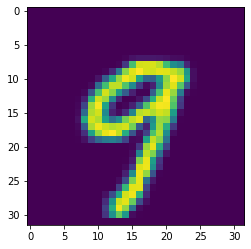

In [52]:
import matplotlib.pyplot as plt
plt.imshow(dataset[45][0].reshape([32,32]))#.permute(1,2,0))
plt.show()

Define da discriminator model, is ur classical CNN with sigmoid activation since its a binary classification, 0 will mean fake, 1 will mean real

In [53]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.cnn = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, kernel_size=5, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
    )
    self.fc = nn.Sequential(
        nn.Linear(1152, 1, bias=False),
        nn.Sigmoid()
    )
    self.batchSize = 1

  def forward(self, x):
    x = self.cnn(x)
    x = x.view([self.batchSize, -1])
    x = self.fc(x)
    return x

In [54]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(50, 256, kernel_size=3, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.ConvTranspose2d(256, 128, kernel_size=4, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, kernel_size=5, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=5, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, kernel_size=6, stride=2, bias=False),
        nn.Tanh()
    )
  
  def forward(self, x):
    x = self.main(x)
    return x

In [55]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [56]:
discrim = Discriminator()
discrim.eval()
discrim(dataset[0][0].unsqueeze(0))
#discrim.apply(weights_init)
discrim.to(device)

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
  )
  (fc): Sequential(
    (0): Linear(in_features=1152, out_features=1, bias=False)
    (1): Sigmoid()
  )
)

In [57]:
gen = Generator()
gen.eval()
rando = torch.randn([1,50,1,1])
print(gen(rando).shape)
#gen.apply(weights_init)
gen.to(device)

torch.Size([1, 1, 32, 32])


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(50, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(32, 1, kernel_size=(6, 6), stride=(2, 2), bias=False)
    (13): Tanh()
  )
)

In [58]:
from PIL import Image
totensor = transforms.ToTensor()

In [59]:
bce = nn.BCELoss()
discrimOptim = optim.Adam(discrim.parameters(), lr=0.0002)

In [60]:
def train_discrim():
  randobatch = torch.randn([batchSize, 50, 1, 1])
  randobatch = randobatch.cuda()
  fakebatch = gen(randobatch)
  runloss = 0.0
  for batch_no, realbatch in enumerate(dataloader):
    #join both batches together
    #realbatch[0] = dataset[100][0].cuda()

    #realbatch[0] = Image.open('./orange32x32.jpg')
    #realbatch[0] = totensor(realbatch[0])

    realbatch[0] = realbatch[0].cuda()
    #realbatch[0] = realbatch[0].reshape([1, 32, 32])
    #realbatch[0] = realbatch[0].repeat(batchSize, 1, 1, 1)

    discrimOptim.zero_grad()

    #compute gradients of real images and fake images on discriminator
    discrim.batchSize = batchSize
    labels = torch.ones([batchSize, 1])
    labels = labels.cuda()
    #labels = labels.reshape([batchSize, 1])
    mainBatch = discrim(realbatch[0])
    loss = bce(mainBatch, labels)
    #loss.backward()
    runloss += loss.item()
    
    labels = torch.zeros([batchSize, 1])
    labels = labels.cuda()
    #labels = labels.reshape()
    mainBatch = discrim(fakebatch)
    loss += bce(mainBatch, labels)
    loss.backward()
    runloss += loss.item()

    discrimOptim.step()

    break
  return runloss

In [61]:
genOptim = optim.Adam(gen.parameters(), lr=0.0002)

In [62]:
def train_gen():
  randobatch = torch.randn([batchSize, 50, 1, 1])
  randobatch = randobatch.cuda()
  fakebatch = gen(randobatch)
  labels = torch.ones(batchSize, 1)
  labels = labels.cuda()
  discrim.batchSize = batchSize
  fakeouts = discrim(fakebatch)

  discrimOptim.zero_grad()
  genOptim.zero_grad()
  loss = bce(fakeouts, labels)
  loss.backward()
  genOptim.step()

  return loss.item()

Entering epoch no: 0
Discriminator loss: 0.4595407247543335
Generator loss: 4.844577789306641
Entering epoch no: 1
Discriminator loss: 0.78146992623806
Generator loss: 25.293800354003906
Entering epoch no: 2
Discriminator loss: 7.661230564117432
Generator loss: 0.24912818148732185
Entering epoch no: 3
Discriminator loss: 3.7796968519687653
Generator loss: 1.5088996589183807
Entering epoch no: 4
Discriminator loss: 2.127677731215954
Generator loss: 12.699995994567871
Entering epoch no: 5
Discriminator loss: 2.315666437149048
Generator loss: 15.722755432128906
Entering epoch no: 6
Discriminator loss: 2.753864049911499
Generator loss: 8.768853664398193
Entering epoch no: 7
Discriminator loss: 2.0780900716781616
Generator loss: 5.6248356103897095
Entering epoch no: 8
Discriminator loss: 2.3000234961509705
Generator loss: 10.808464050292969
Entering epoch no: 9
Discriminator loss: 2.2115092277526855
Generator loss: 16.326021194458008
Entering epoch no: 10
Discriminator loss: 3.4483395814895

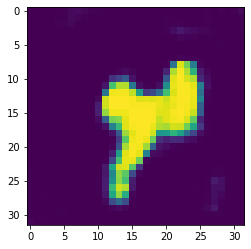

Discriminator out for this image: tensor([[0.0060]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 20
Discriminator loss: 0.1696668565273285
Generator loss: 48.026920318603516
Entering epoch no: 21
Discriminator loss: 0.09302714094519615
Generator loss: 41.02761363983154
Entering epoch no: 22
Discriminator loss: 0.15418551862239838
Generator loss: 29.075373649597168
Entering epoch no: 23
Discriminator loss: 0.13122795149683952
Generator loss: 21.44148588180542
Entering epoch no: 24
Discriminator loss: 0.36384791135787964
Generator loss: 15.927388191223145
Entering epoch no: 25
Discriminator loss: 0.9008833765983582
Generator loss: 12.98227834701538
Entering epoch no: 26
Discriminator loss: 1.2657475173473358
Generator loss: 13.0663423538208
Entering epoch no: 27
Discriminator loss: 1.072404608130455
Generator loss: 13.47500205039978
Entering epoch no: 28
Discriminator loss: 0.8173341453075409
Generator loss: 15.63646125793457
Entering epoch no: 29
Discriminator loss: 1

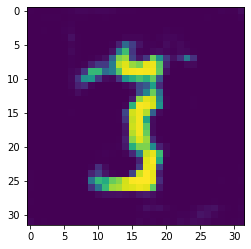

Discriminator out for this image: tensor([[0.0037]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 40
Discriminator loss: 0.5560654550790787
Generator loss: 13.69852352142334
Entering epoch no: 41
Discriminator loss: 0.7075982987880707
Generator loss: 12.882653951644897
Entering epoch no: 42
Discriminator loss: 0.5375315099954605
Generator loss: 12.258071660995483
Entering epoch no: 43
Discriminator loss: 0.3839106857776642
Generator loss: 12.41537094116211
Entering epoch no: 44
Discriminator loss: 0.27795015275478363
Generator loss: 11.274374723434448
Entering epoch no: 45
Discriminator loss: 0.42270897328853607
Generator loss: 10.874192476272583
Entering epoch no: 46
Discriminator loss: 0.37767641246318817
Generator loss: 11.874369621276855
Entering epoch no: 47
Discriminator loss: 0.4412619322538376
Generator loss: 11.513933181762695
Entering epoch no: 48
Discriminator loss: 0.4189735949039459
Generator loss: 11.694390296936035
Entering epoch no: 49
Discriminator lo

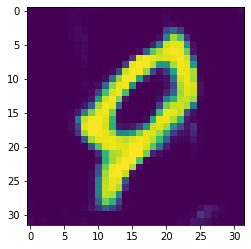

Discriminator out for this image: tensor([[0.0492]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 60
Discriminator loss: 0.15873996168375015
Generator loss: 12.783297300338745
Entering epoch no: 61
Discriminator loss: 0.5550648272037506
Generator loss: 12.116817235946655
Entering epoch no: 62
Discriminator loss: 0.5192747861146927
Generator loss: 11.56238055229187
Entering epoch no: 63
Discriminator loss: 0.4466388076543808
Generator loss: 8.908112049102783
Entering epoch no: 64
Discriminator loss: 0.20486949384212494
Generator loss: 8.763859510421753
Entering epoch no: 65
Discriminator loss: 0.20182377472519875
Generator loss: 8.218089580535889
Entering epoch no: 66
Discriminator loss: 0.18804779648780823
Generator loss: 8.714846134185791
Entering epoch no: 67
Discriminator loss: 0.2973933592438698
Generator loss: 10.819592475891113
Entering epoch no: 68
Discriminator loss: 0.1600201651453972
Generator loss: 11.454561233520508
Entering epoch no: 69
Discriminator loss

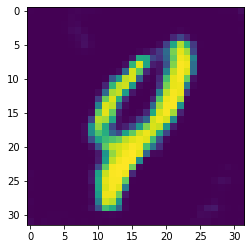

Discriminator out for this image: tensor([[0.0444]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 80
Discriminator loss: 0.4657781720161438
Generator loss: 12.511188507080078
Entering epoch no: 81
Discriminator loss: 0.38311752676963806
Generator loss: 13.23421859741211
Entering epoch no: 82
Discriminator loss: 0.2519214078783989
Generator loss: 13.519349098205566
Entering epoch no: 83
Discriminator loss: 0.833491176366806
Generator loss: 13.175601959228516
Entering epoch no: 84
Discriminator loss: 0.3697221428155899
Generator loss: 10.612621545791626
Entering epoch no: 85
Discriminator loss: 0.16750308871269226
Generator loss: 10.054723262786865
Entering epoch no: 86
Discriminator loss: 0.2823900803923607
Generator loss: 9.617704391479492
Entering epoch no: 87
Discriminator loss: 0.18176237121224403
Generator loss: 10.370331048965454
Entering epoch no: 88
Discriminator loss: 0.27242934703826904
Generator loss: 11.654610872268677
Entering epoch no: 89
Discriminator lo

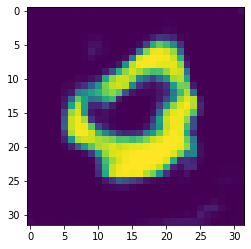

Discriminator out for this image: tensor([[0.1050]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 100
Discriminator loss: 0.17311208695173264
Generator loss: 9.41404676437378
Entering epoch no: 101
Discriminator loss: 0.2210441380739212
Generator loss: 11.929361820220947
Entering epoch no: 102
Discriminator loss: 0.30472975969314575
Generator loss: 11.328943967819214
Entering epoch no: 103
Discriminator loss: 0.32609544694423676
Generator loss: 12.393551349639893
Entering epoch no: 104
Discriminator loss: 0.2678125649690628
Generator loss: 12.133752822875977
Entering epoch no: 105
Discriminator loss: 0.5830494463443756
Generator loss: 10.096794843673706
Entering epoch no: 106
Discriminator loss: 0.33456897735595703
Generator loss: 9.826457500457764
Entering epoch no: 107
Discriminator loss: 0.48292413353919983
Generator loss: 7.772566795349121
Entering epoch no: 108
Discriminator loss: 0.3197088837623596
Generator loss: 7.0200300216674805
Entering epoch no: 109
Discri

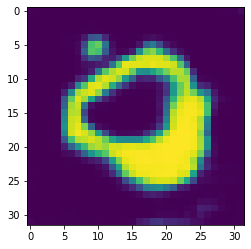

Discriminator out for this image: tensor([[0.0528]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 120
Discriminator loss: 0.27813026309013367
Generator loss: 12.382715225219727
Entering epoch no: 121
Discriminator loss: 0.48429954051971436
Generator loss: 10.994810819625854
Entering epoch no: 122
Discriminator loss: 0.40462468564510345
Generator loss: 10.491295576095581
Entering epoch no: 123
Discriminator loss: 0.24515227228403091
Generator loss: 9.792685508728027
Entering epoch no: 124
Discriminator loss: 0.20628491789102554
Generator loss: 8.99356722831726
Entering epoch no: 125
Discriminator loss: 0.21652103960514069
Generator loss: 8.439624071121216
Entering epoch no: 126
Discriminator loss: 0.42185960710048676
Generator loss: 8.65992259979248
Entering epoch no: 127
Discriminator loss: 0.1732201799750328
Generator loss: 12.048152685165405
Entering epoch no: 128
Discriminator loss: 0.22510232776403427
Generator loss: 10.54937195777893
Entering epoch no: 129
Discri

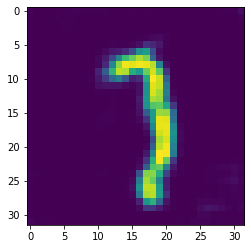

Discriminator out for this image: tensor([[0.0412]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 140
Discriminator loss: 0.2533790096640587
Generator loss: 9.477128744125366
Entering epoch no: 141
Discriminator loss: 0.279130756855011
Generator loss: 7.208868503570557
Entering epoch no: 142
Discriminator loss: 0.19299151748418808
Generator loss: 7.978290319442749
Entering epoch no: 143
Discriminator loss: 0.4160551130771637
Generator loss: 9.067614078521729
Entering epoch no: 144
Discriminator loss: 0.3137597143650055
Generator loss: 10.619956016540527
Entering epoch no: 145
Discriminator loss: 0.2525605633854866
Generator loss: 12.215083122253418
Entering epoch no: 146
Discriminator loss: 0.37435637414455414
Generator loss: 13.091015338897705
Entering epoch no: 147
Discriminator loss: 0.3560514897108078
Generator loss: 13.363677501678467
Entering epoch no: 148
Discriminator loss: 0.3010108768939972
Generator loss: 11.331066608428955
Entering epoch no: 149
Discrimina

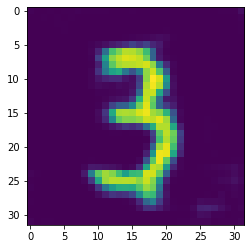

Discriminator out for this image: tensor([[0.0164]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 160
Discriminator loss: 0.28394588083028793
Generator loss: 9.355352878570557
Entering epoch no: 161
Discriminator loss: 0.15130223333835602
Generator loss: 9.442664623260498
Entering epoch no: 162
Discriminator loss: 0.18994034826755524
Generator loss: 10.826112747192383
Entering epoch no: 163
Discriminator loss: 0.14103807881474495
Generator loss: 11.032893180847168
Entering epoch no: 164
Discriminator loss: 0.22276528179645538
Generator loss: 11.71501636505127
Entering epoch no: 165
Discriminator loss: 0.44284892082214355
Generator loss: 12.03488278388977
Entering epoch no: 166
Discriminator loss: 0.21953023970127106
Generator loss: 10.570394515991211
Entering epoch no: 167
Discriminator loss: 0.2806948274374008
Generator loss: 11.222129106521606
Entering epoch no: 168
Discriminator loss: 0.322179839015007
Generator loss: 9.788958549499512
Entering epoch no: 169
Discri

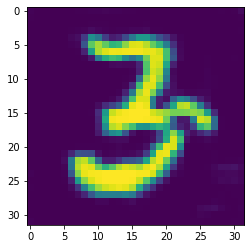

Discriminator out for this image: tensor([[0.0420]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 180
Discriminator loss: 0.05473590828478336
Generator loss: 11.59232473373413
Entering epoch no: 181
Discriminator loss: 0.1409701555967331
Generator loss: 11.412397861480713
Entering epoch no: 182
Discriminator loss: 0.24272175133228302
Generator loss: 11.1347336769104
Entering epoch no: 183
Discriminator loss: 0.1755901426076889
Generator loss: 12.224034309387207
Entering epoch no: 184
Discriminator loss: 0.4442957639694214
Generator loss: 11.093063831329346
Entering epoch no: 185
Discriminator loss: 0.1434333436191082
Generator loss: 11.738940954208374
Entering epoch no: 186
Discriminator loss: 0.05922142509371042
Generator loss: 10.502744197845459
Entering epoch no: 187
Discriminator loss: 0.11599799245595932
Generator loss: 11.401259422302246
Entering epoch no: 188
Discriminator loss: 0.1582588329911232
Generator loss: 12.223598003387451
Entering epoch no: 189
Discri

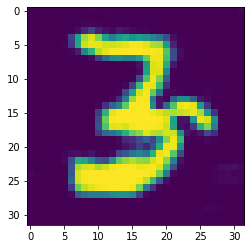

Discriminator out for this image: tensor([[0.0720]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 200
Discriminator loss: 0.19743534922599792
Generator loss: 11.196939468383789
Entering epoch no: 201
Discriminator loss: 0.11477884650230408
Generator loss: 11.193503618240356
Entering epoch no: 202
Discriminator loss: 0.10806805081665516
Generator loss: 12.01732087135315
Entering epoch no: 203
Discriminator loss: 0.33515800535678864
Generator loss: 11.397679328918457
Entering epoch no: 204
Discriminator loss: 0.16657231748104095
Generator loss: 11.593222618103027
Entering epoch no: 205
Discriminator loss: 0.21762335300445557
Generator loss: 11.392931938171387
Entering epoch no: 206
Discriminator loss: 0.2652817368507385
Generator loss: 11.57033634185791
Entering epoch no: 207
Discriminator loss: 0.32558003067970276
Generator loss: 10.063385486602783
Entering epoch no: 208
Discriminator loss: 0.20479346066713333
Generator loss: 10.55741834640503
Entering epoch no: 209
Di

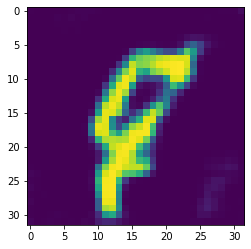

Discriminator out for this image: tensor([[0.0309]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 220
Discriminator loss: 0.2962169349193573
Generator loss: 11.141537189483643
Entering epoch no: 221
Discriminator loss: 0.2633399963378906
Generator loss: 10.898455142974854
Entering epoch no: 222
Discriminator loss: 0.1838320791721344
Generator loss: 11.24425721168518
Entering epoch no: 223
Discriminator loss: 0.25245122611522675
Generator loss: 10.677650690078735
Entering epoch no: 224
Discriminator loss: 0.15488504990935326
Generator loss: 9.86602258682251
Entering epoch no: 225
Discriminator loss: 0.26039427518844604
Generator loss: 9.335426330566406
Entering epoch no: 226
Discriminator loss: 0.15034369379281998
Generator loss: 8.824862480163574
Entering epoch no: 227
Discriminator loss: 0.22060175985097885
Generator loss: 7.948339939117432
Entering epoch no: 228
Discriminator loss: 0.11634897068142891
Generator loss: 9.463440179824829
Entering epoch no: 229
Discrimi

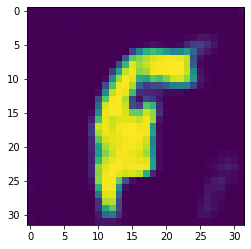

Discriminator out for this image: tensor([[0.1395]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 240
Discriminator loss: 0.19670283794403076
Generator loss: 8.264925956726074
Entering epoch no: 241
Discriminator loss: 0.38093335926532745
Generator loss: 8.147993564605713
Entering epoch no: 242
Discriminator loss: 0.4613475054502487
Generator loss: 8.961415529251099
Entering epoch no: 243
Discriminator loss: 0.23061035573482513
Generator loss: 9.191037893295288
Entering epoch no: 244
Discriminator loss: 0.20710644125938416
Generator loss: 9.533186912536621
Entering epoch no: 245
Discriminator loss: 0.40234605967998505
Generator loss: 11.493632078170776
Entering epoch no: 246
Discriminator loss: 0.3143308162689209
Generator loss: 9.794909715652466
Entering epoch no: 247
Discriminator loss: 0.35989533364772797
Generator loss: 9.686782121658325
Entering epoch no: 248
Discriminator loss: 0.3859352618455887
Generator loss: 8.38778042793274
Entering epoch no: 249
Discrimina

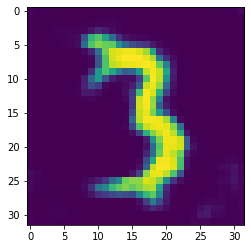

Discriminator out for this image: tensor([[0.0549]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 260
Discriminator loss: 0.26253972947597504
Generator loss: 6.6529728174209595
Entering epoch no: 261
Discriminator loss: 0.4340100660920143
Generator loss: 6.528834104537964
Entering epoch no: 262
Discriminator loss: 0.3821834921836853
Generator loss: 7.926559209823608
Entering epoch no: 263
Discriminator loss: 0.3462163731455803
Generator loss: 9.233828783035278
Entering epoch no: 264
Discriminator loss: 0.38065803050994873
Generator loss: 10.922504425048828
Entering epoch no: 265
Discriminator loss: 0.36020006239414215
Generator loss: 12.986976146697998
Entering epoch no: 266
Discriminator loss: 0.2938060015439987
Generator loss: 13.113619804382324
Entering epoch no: 267
Discriminator loss: 0.299718976020813
Generator loss: 14.108964920043945
Entering epoch no: 268
Discriminator loss: 0.3916648179292679
Generator loss: 12.029862880706787
Entering epoch no: 269
Discrimi

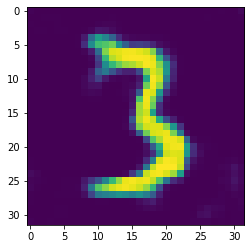

Discriminator out for this image: tensor([[0.0245]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 280
Discriminator loss: 0.17392796277999878
Generator loss: 12.703176975250244
Entering epoch no: 281
Discriminator loss: 0.2525387182831764
Generator loss: 12.651107788085938
Entering epoch no: 282
Discriminator loss: 0.1379668265581131
Generator loss: 11.769407987594604
Entering epoch no: 283
Discriminator loss: 0.10600546002388
Generator loss: 11.072548627853394
Entering epoch no: 284
Discriminator loss: 0.33607183396816254
Generator loss: 10.423402070999146
Entering epoch no: 285
Discriminator loss: 0.14120808243751526
Generator loss: 10.537552833557129
Entering epoch no: 286
Discriminator loss: 0.15925849974155426
Generator loss: 9.577431201934814
Entering epoch no: 287
Discriminator loss: 0.1684199422597885
Generator loss: 9.811786651611328
Entering epoch no: 288
Discriminator loss: 0.11848323047161102
Generator loss: 10.349965572357178
Entering epoch no: 289
Discri

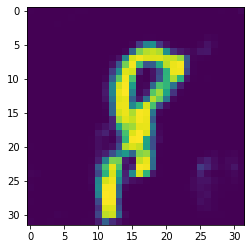

Discriminator out for this image: tensor([[0.0787]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 300
Discriminator loss: 0.17045184969902039
Generator loss: 12.52858829498291
Entering epoch no: 301
Discriminator loss: 0.18566063791513443
Generator loss: 11.2621169090271
Entering epoch no: 302
Discriminator loss: 0.13149265199899673
Generator loss: 12.059223651885986
Entering epoch no: 303
Discriminator loss: 0.10196314193308353
Generator loss: 11.99215054512024
Entering epoch no: 304
Discriminator loss: 0.2147783860564232
Generator loss: 13.176901817321777
Entering epoch no: 305
Discriminator loss: 0.20640063285827637
Generator loss: 12.63377046585083
Entering epoch no: 306
Discriminator loss: 0.16353967040777206
Generator loss: 14.291717052459717
Entering epoch no: 307
Discriminator loss: 0.13381211832165718
Generator loss: 13.24561095237732
Entering epoch no: 308
Discriminator loss: 0.19438841938972473
Generator loss: 12.673227787017822
Entering epoch no: 309
Discr

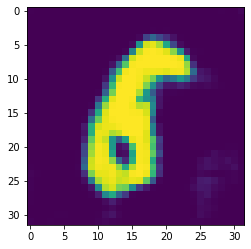

Discriminator out for this image: tensor([[0.0161]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 320
Discriminator loss: 0.2978578060865402
Generator loss: 11.950452327728271
Entering epoch no: 321
Discriminator loss: 0.44577041268348694
Generator loss: 12.000460863113403
Entering epoch no: 322
Discriminator loss: 0.1935335099697113
Generator loss: 11.448591947555542
Entering epoch no: 323
Discriminator loss: 0.19426218420267105
Generator loss: 9.936402082443237
Entering epoch no: 324
Discriminator loss: 0.2467753067612648
Generator loss: 10.477415561676025
Entering epoch no: 325
Discriminator loss: 0.23980535566806793
Generator loss: 9.656752109527588
Entering epoch no: 326
Discriminator loss: 0.32126186043024063
Generator loss: 8.597333669662476
Entering epoch no: 327
Discriminator loss: 0.31220291554927826
Generator loss: 9.246866703033447
Entering epoch no: 328
Discriminator loss: 0.24817953258752823
Generator loss: 8.729470491409302
Entering epoch no: 329
Discri

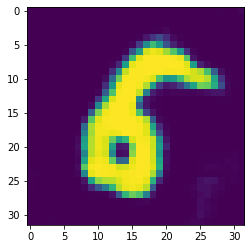

Discriminator out for this image: tensor([[0.0666]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 340
Discriminator loss: 0.2671040669083595
Generator loss: 9.474853277206421
Entering epoch no: 341
Discriminator loss: 0.10068555362522602
Generator loss: 9.731808185577393
Entering epoch no: 342
Discriminator loss: 0.21924946457147598
Generator loss: 10.57103180885315
Entering epoch no: 343
Discriminator loss: 0.06973209045827389
Generator loss: 10.060704469680786
Entering epoch no: 344
Discriminator loss: 0.309973880648613
Generator loss: 10.8722665309906
Entering epoch no: 345
Discriminator loss: 0.23161663860082626
Generator loss: 12.105629920959473
Entering epoch no: 346
Discriminator loss: 0.2300257533788681
Generator loss: 11.86027216911316
Entering epoch no: 347
Discriminator loss: 0.32528965175151825
Generator loss: 11.384725093841553
Entering epoch no: 348
Discriminator loss: 0.27177152037620544
Generator loss: 11.69698190689087
Entering epoch no: 349
Discrimin

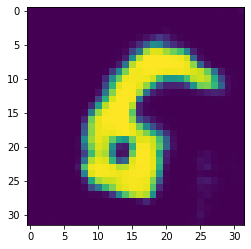

Discriminator out for this image: tensor([[0.0168]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 360
Discriminator loss: 0.209720179438591
Generator loss: 9.671390533447266
Entering epoch no: 361
Discriminator loss: 0.23850667476654053
Generator loss: 9.515613555908203
Entering epoch no: 362
Discriminator loss: 0.31451675295829773
Generator loss: 9.428704738616943
Entering epoch no: 363
Discriminator loss: 0.17283155024051666
Generator loss: 10.741085767745972
Entering epoch no: 364
Discriminator loss: 0.19677042216062546
Generator loss: 10.391587257385254
Entering epoch no: 365
Discriminator loss: 0.2896527126431465
Generator loss: 9.631636381149292
Entering epoch no: 366
Discriminator loss: 0.32262273132801056
Generator loss: 10.704428672790527
Entering epoch no: 367
Discriminator loss: 0.12567967921495438
Generator loss: 11.655019760131836
Entering epoch no: 368
Discriminator loss: 0.29731234908103943
Generator loss: 11.530765533447266
Entering epoch no: 369
Discr

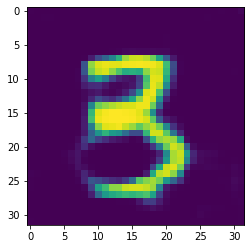

Discriminator out for this image: tensor([[0.0835]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 380
Discriminator loss: 0.3574523329734802
Generator loss: 9.013750553131104
Entering epoch no: 381
Discriminator loss: 0.4483534097671509
Generator loss: 9.273000001907349
Entering epoch no: 382
Discriminator loss: 0.37734851241111755
Generator loss: 10.082902431488037
Entering epoch no: 383
Discriminator loss: 0.24864067137241364
Generator loss: 10.875588178634644
Entering epoch no: 384
Discriminator loss: 0.18735677003860474
Generator loss: 9.29875922203064
Entering epoch no: 385
Discriminator loss: 0.1731046512722969
Generator loss: 9.4032301902771
Entering epoch no: 386
Discriminator loss: 0.2123735398054123
Generator loss: 9.995160341262817
Entering epoch no: 387
Discriminator loss: 0.5299857258796692
Generator loss: 9.980415105819702
Entering epoch no: 388
Discriminator loss: 0.20556282997131348
Generator loss: 9.480810165405273
Entering epoch no: 389
Discriminator

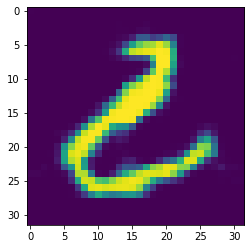

Discriminator out for this image: tensor([[0.0594]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 400
Discriminator loss: 0.21952637657523155
Generator loss: 10.066125392913818
Entering epoch no: 401
Discriminator loss: 0.46752282977104187
Generator loss: 10.280155181884766
Entering epoch no: 402
Discriminator loss: 0.20288779586553574
Generator loss: 9.203787803649902
Entering epoch no: 403
Discriminator loss: 0.18685165792703629
Generator loss: 9.268678188323975
Entering epoch no: 404
Discriminator loss: 0.11630640923976898
Generator loss: 9.807994604110718
Entering epoch no: 405
Discriminator loss: 0.17503587901592255
Generator loss: 10.598519325256348
Entering epoch no: 406
Discriminator loss: 0.2722792252898216
Generator loss: 12.733262538909912
Entering epoch no: 407
Discriminator loss: 0.18164017796516418
Generator loss: 12.739185810089111
Entering epoch no: 408
Discriminator loss: 0.1946360170841217
Generator loss: 10.693254232406616
Entering epoch no: 409
Dis

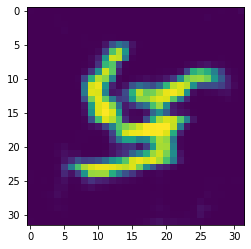

Discriminator out for this image: tensor([[0.0955]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 420
Discriminator loss: 0.15333780646324158
Generator loss: 10.430315256118774
Entering epoch no: 421
Discriminator loss: 0.18436941131949425
Generator loss: 12.464952945709229
Entering epoch no: 422
Discriminator loss: 0.1624819114804268
Generator loss: 11.46259069442749
Entering epoch no: 423
Discriminator loss: 0.3386492133140564
Generator loss: 12.314399242401123
Entering epoch no: 424
Discriminator loss: 0.28842969238758087
Generator loss: 11.974019765853882
Entering epoch no: 425
Discriminator loss: 0.19880633056163788
Generator loss: 12.200180053710938
Entering epoch no: 426
Discriminator loss: 0.25419241189956665
Generator loss: 12.168797969818115
Entering epoch no: 427
Discriminator loss: 0.28962242603302
Generator loss: 11.682790756225586
Entering epoch no: 428
Discriminator loss: 0.17072083055973053
Generator loss: 11.26723861694336
Entering epoch no: 429
Discr

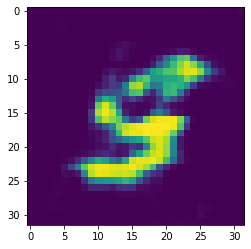

Discriminator out for this image: tensor([[0.3384]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 440
Discriminator loss: 0.1722012311220169
Generator loss: 9.183531284332275
Entering epoch no: 441
Discriminator loss: 0.1448308862745762
Generator loss: 8.054333209991455
Entering epoch no: 442
Discriminator loss: 0.20367936044931412
Generator loss: 8.807794094085693
Entering epoch no: 443
Discriminator loss: 0.23586713895201683
Generator loss: 9.163151264190674
Entering epoch no: 444
Discriminator loss: 0.23120196163654327
Generator loss: 10.654995679855347
Entering epoch no: 445
Discriminator loss: 0.19750354811549187
Generator loss: 11.900022745132446
Entering epoch no: 446
Discriminator loss: 0.23087980598211288
Generator loss: 13.698328495025635
Entering epoch no: 447
Discriminator loss: 0.43706515431404114
Generator loss: 13.52159309387207
Entering epoch no: 448
Discriminator loss: 0.24331574141979218
Generator loss: 12.313139915466309
Entering epoch no: 449
Discr

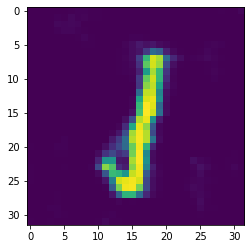

Discriminator out for this image: tensor([[0.0467]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 460
Discriminator loss: 0.28762971609830856
Generator loss: 8.329203128814697
Entering epoch no: 461
Discriminator loss: 0.5169618725776672
Generator loss: 6.4836649894714355
Entering epoch no: 462
Discriminator loss: 0.3582541085779667
Generator loss: 7.961973428726196
Entering epoch no: 463
Discriminator loss: 0.4070015475153923
Generator loss: 8.039107322692871
Entering epoch no: 464
Discriminator loss: 0.37104497849941254
Generator loss: 9.026555061340332
Entering epoch no: 465
Discriminator loss: 0.47091513872146606
Generator loss: 9.80952763557434
Entering epoch no: 466
Discriminator loss: 0.8958948850631714
Generator loss: 9.282475471496582
Entering epoch no: 467
Discriminator loss: 0.5829951167106628
Generator loss: 8.143085956573486
Entering epoch no: 468
Discriminator loss: 0.6019727289676666
Generator loss: 6.828398704528809
Entering epoch no: 469
Discriminator

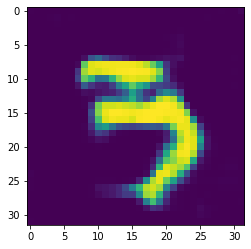

Discriminator out for this image: tensor([[0.0115]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 480
Discriminator loss: 0.4427643120288849
Generator loss: 6.762216806411743
Entering epoch no: 481
Discriminator loss: 0.31687717139720917
Generator loss: 8.052324771881104
Entering epoch no: 482
Discriminator loss: 0.27781906723976135
Generator loss: 7.777092933654785
Entering epoch no: 483
Discriminator loss: 0.23092323914170265
Generator loss: 7.181687593460083
Entering epoch no: 484
Discriminator loss: 0.3416644036769867
Generator loss: 8.389649391174316
Entering epoch no: 485
Discriminator loss: 0.3276068940758705
Generator loss: 10.710749387741089
Entering epoch no: 486
Discriminator loss: 0.11985007673501968
Generator loss: 13.241520643234253
Entering epoch no: 487
Discriminator loss: 0.22141757607460022
Generator loss: 13.178720951080322
Entering epoch no: 488
Discriminator loss: 0.2246183529496193
Generator loss: 12.663177013397217
Entering epoch no: 489
Discrim

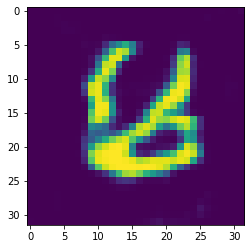

Discriminator out for this image: tensor([[0.0118]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 500
Discriminator loss: 0.19277805089950562
Generator loss: 10.58860158920288
Entering epoch no: 501
Discriminator loss: 0.18289971351623535
Generator loss: 8.58310079574585
Entering epoch no: 502
Discriminator loss: 0.19626696407794952
Generator loss: 8.248510122299194
Entering epoch no: 503
Discriminator loss: 0.19635457918047905
Generator loss: 8.60690188407898
Entering epoch no: 504
Discriminator loss: 0.171750046312809
Generator loss: 8.766769170761108
Entering epoch no: 505
Discriminator loss: 0.13778141513466835
Generator loss: 9.730192422866821
Entering epoch no: 506
Discriminator loss: 0.1634698621928692
Generator loss: 10.911590576171875
Entering epoch no: 507
Discriminator loss: 0.21400394290685654
Generator loss: 12.110057830810547
Entering epoch no: 508
Discriminator loss: 0.19746452569961548
Generator loss: 12.22733736038208
Entering epoch no: 509
Discrimina

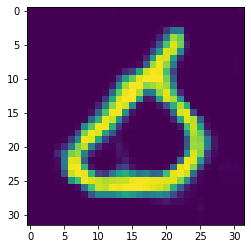

Discriminator out for this image: tensor([[0.0300]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 520
Discriminator loss: 0.21631108969449997
Generator loss: 10.689936876296997
Entering epoch no: 521
Discriminator loss: 0.260522723197937
Generator loss: 12.602165222167969
Entering epoch no: 522
Discriminator loss: 0.13786419481039047
Generator loss: 13.328991889953613
Entering epoch no: 523
Discriminator loss: 0.434477835893631
Generator loss: 11.879242897033691
Entering epoch no: 524
Discriminator loss: 0.5280391871929169
Generator loss: 10.834279537200928
Entering epoch no: 525
Discriminator loss: 0.41870081424713135
Generator loss: 8.249138593673706
Entering epoch no: 526
Discriminator loss: 0.27276596426963806
Generator loss: 7.702347993850708
Entering epoch no: 527
Discriminator loss: 0.2851794734597206
Generator loss: 8.02397632598877
Entering epoch no: 528
Discriminator loss: 0.43988849222660065
Generator loss: 9.28817892074585
Entering epoch no: 529
Discrimina

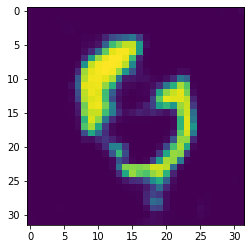

Discriminator out for this image: tensor([[0.0563]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 540
Discriminator loss: 0.20690784603357315
Generator loss: 8.85948657989502
Entering epoch no: 541
Discriminator loss: 0.3384110853075981
Generator loss: 8.262315273284912
Entering epoch no: 542
Discriminator loss: 0.2787707671523094
Generator loss: 7.977198123931885
Entering epoch no: 543
Discriminator loss: 0.2778795212507248
Generator loss: 9.314371347427368
Entering epoch no: 544
Discriminator loss: 0.40757256746292114
Generator loss: 9.740038394927979
Entering epoch no: 545
Discriminator loss: 0.3517660051584244
Generator loss: 9.766092777252197
Entering epoch no: 546
Discriminator loss: 0.3867710828781128
Generator loss: 10.436818361282349
Entering epoch no: 547
Discriminator loss: 0.22826102375984192
Generator loss: 9.865347146987915
Entering epoch no: 548
Discriminator loss: 0.2617279663681984
Generator loss: 9.652469158172607
Entering epoch no: 549
Discriminator

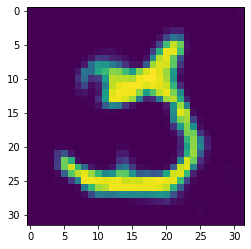

Discriminator out for this image: tensor([[0.0102]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 560
Discriminator loss: 0.3868372291326523
Generator loss: 10.441215515136719
Entering epoch no: 561
Discriminator loss: 0.3271350562572479
Generator loss: 8.97863245010376
Entering epoch no: 562
Discriminator loss: 0.23214395344257355
Generator loss: 8.706464767456055
Entering epoch no: 563
Discriminator loss: 0.25954072922468185
Generator loss: 9.262571573257446
Entering epoch no: 564
Discriminator loss: 0.1714806854724884
Generator loss: 9.253458023071289
Entering epoch no: 565
Discriminator loss: 0.23216448724269867
Generator loss: 9.579473972320557
Entering epoch no: 566
Discriminator loss: 0.27180059999227524
Generator loss: 10.071965456008911
Entering epoch no: 567
Discriminator loss: 0.2382245510816574
Generator loss: 11.60482382774353
Entering epoch no: 568
Discriminator loss: 0.2048778161406517
Generator loss: 9.730773210525513
Entering epoch no: 569
Discriminat

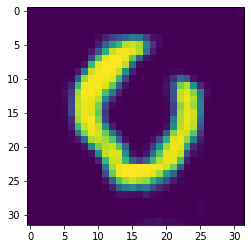

Discriminator out for this image: tensor([[0.0560]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 580
Discriminator loss: 0.3063164949417114
Generator loss: 10.892352104187012
Entering epoch no: 581
Discriminator loss: 0.4714593142271042
Generator loss: 9.940569400787354
Entering epoch no: 582
Discriminator loss: 0.14424103684723377
Generator loss: 9.655059337615967
Entering epoch no: 583
Discriminator loss: 0.2226574867963791
Generator loss: 11.380544185638428
Entering epoch no: 584
Discriminator loss: 0.29267334192991257
Generator loss: 10.900077104568481
Entering epoch no: 585
Discriminator loss: 0.20402421057224274
Generator loss: 10.755236625671387
Entering epoch no: 586
Discriminator loss: 0.11962439492344856
Generator loss: 9.979079246520996
Entering epoch no: 587
Discriminator loss: 0.09355850610882044
Generator loss: 9.98866868019104
Entering epoch no: 588
Discriminator loss: 0.19271423667669296
Generator loss: 10.724191427230835
Entering epoch no: 589
Discri

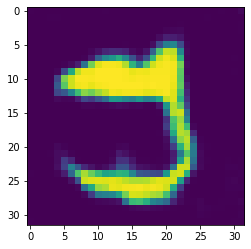

Discriminator out for this image: tensor([[0.0287]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 600
Discriminator loss: 0.45746999979019165
Generator loss: 12.773272514343262
Entering epoch no: 601
Discriminator loss: 0.9057495892047882
Generator loss: 10.693098306655884
Entering epoch no: 602
Discriminator loss: 0.2626960724592209
Generator loss: 7.794911861419678
Entering epoch no: 603
Discriminator loss: 0.369919553399086
Generator loss: 7.253636717796326
Entering epoch no: 604
Discriminator loss: 0.283368855714798
Generator loss: 6.688166618347168
Entering epoch no: 605
Discriminator loss: 0.40252193808555603
Generator loss: 8.256328582763672
Entering epoch no: 606
Discriminator loss: 0.4316551983356476
Generator loss: 9.075288772583008
Entering epoch no: 607
Discriminator loss: 0.29557227343320847
Generator loss: 9.50676965713501
Entering epoch no: 608
Discriminator loss: 0.22225595265626907
Generator loss: 12.060410976409912
Entering epoch no: 609
Discriminato

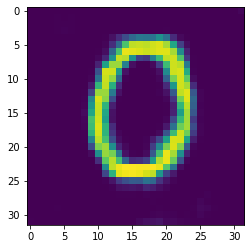

Discriminator out for this image: tensor([[0.0440]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 620
Discriminator loss: 0.3506562113761902
Generator loss: 10.654385805130005
Entering epoch no: 621
Discriminator loss: 0.23552963137626648
Generator loss: 10.066822528839111
Entering epoch no: 622
Discriminator loss: 0.6498556733131409
Generator loss: 8.667913675308228
Entering epoch no: 623
Discriminator loss: 0.1292330101132393
Generator loss: 8.453914642333984
Entering epoch no: 624
Discriminator loss: 0.21811138093471527
Generator loss: 8.484909772872925
Entering epoch no: 625
Discriminator loss: 0.18620388209819794
Generator loss: 9.269426107406616
Entering epoch no: 626
Discriminator loss: 0.2326137125492096
Generator loss: 10.0943284034729
Entering epoch no: 627
Discriminator loss: 0.2053123414516449
Generator loss: 11.487812757492065
Entering epoch no: 628
Discriminator loss: 0.7280603349208832
Generator loss: 11.18475604057312
Entering epoch no: 629
Discriminat

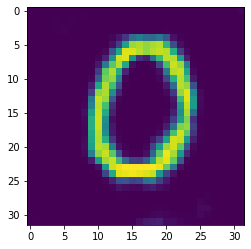

Discriminator out for this image: tensor([[0.0363]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 640
Discriminator loss: 0.3210708945989609
Generator loss: 7.88383150100708
Entering epoch no: 641
Discriminator loss: 0.182648167014122
Generator loss: 7.542668342590332
Entering epoch no: 642
Discriminator loss: 0.3111792504787445
Generator loss: 8.770747661590576
Entering epoch no: 643
Discriminator loss: 0.2970564290881157
Generator loss: 9.726086378097534
Entering epoch no: 644
Discriminator loss: 0.21668671816587448
Generator loss: 10.74924373626709
Entering epoch no: 645
Discriminator loss: 0.2930511385202408
Generator loss: 12.257818222045898
Entering epoch no: 646
Discriminator loss: 0.29508912563323975
Generator loss: 12.222529649734497
Entering epoch no: 647
Discriminator loss: 0.402149498462677
Generator loss: 14.250460147857666
Entering epoch no: 648
Discriminator loss: 0.7257791757583618
Generator loss: 12.30756950378418
Entering epoch no: 649
Discriminator 

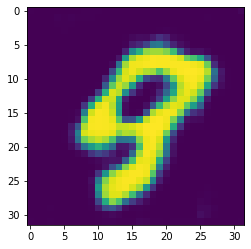

Discriminator out for this image: tensor([[0.0469]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 660
Discriminator loss: 0.3248858079314232
Generator loss: 7.502710580825806
Entering epoch no: 661
Discriminator loss: 0.3757593184709549
Generator loss: 7.789802074432373
Entering epoch no: 662
Discriminator loss: 0.4522271230816841
Generator loss: 9.906564474105835
Entering epoch no: 663
Discriminator loss: 0.5237478166818619
Generator loss: 12.125808954238892
Entering epoch no: 664
Discriminator loss: 0.7693271040916443
Generator loss: 12.113786935806274
Entering epoch no: 665
Discriminator loss: 0.8162422180175781
Generator loss: 10.622122764587402
Entering epoch no: 666
Discriminator loss: 0.7739608287811279
Generator loss: 7.3911590576171875
Entering epoch no: 667
Discriminator loss: 0.3967888653278351
Generator loss: 5.364439010620117
Entering epoch no: 668
Discriminator loss: 0.4044414833188057
Generator loss: 5.777296185493469
Entering epoch no: 669
Discriminato

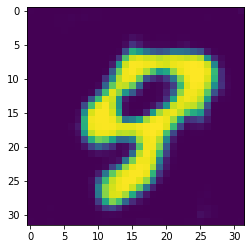

Discriminator out for this image: tensor([[0.0875]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 680
Discriminator loss: 0.21313627064228058
Generator loss: 12.463295936584473
Entering epoch no: 681
Discriminator loss: 0.3486047089099884
Generator loss: 13.256227016448975
Entering epoch no: 682
Discriminator loss: 0.2369634360074997
Generator loss: 15.080026149749756
Entering epoch no: 683
Discriminator loss: 0.37148790061473846
Generator loss: 13.495429039001465
Entering epoch no: 684
Discriminator loss: 0.2783493995666504
Generator loss: 12.61208438873291
Entering epoch no: 685
Discriminator loss: 0.29629573225975037
Generator loss: 10.860473155975342
Entering epoch no: 686
Discriminator loss: 0.2771720066666603
Generator loss: 8.629802703857422
Entering epoch no: 687
Discriminator loss: 0.1847623959183693
Generator loss: 8.27986764907837
Entering epoch no: 688
Discriminator loss: 0.2670288383960724
Generator loss: 7.888895511627197
Entering epoch no: 689
Discrimin

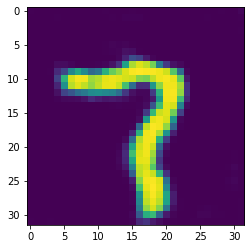

Discriminator out for this image: tensor([[0.3073]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 700
Discriminator loss: 0.2570347413420677
Generator loss: 9.128612041473389
Entering epoch no: 701
Discriminator loss: 0.19128449261188507
Generator loss: 10.904204845428467
Entering epoch no: 702
Discriminator loss: 0.11546452715992928
Generator loss: 12.460723400115967
Entering epoch no: 703
Discriminator loss: 0.0913049466907978
Generator loss: 13.178534507751465
Entering epoch no: 704
Discriminator loss: 0.3929164409637451
Generator loss: 13.793942928314209
Entering epoch no: 705
Discriminator loss: 0.2552369013428688
Generator loss: 14.430668830871582
Entering epoch no: 706
Discriminator loss: 0.6432952582836151
Generator loss: 11.42891001701355
Entering epoch no: 707
Discriminator loss: 0.39419716596603394
Generator loss: 10.18229603767395
Entering epoch no: 708
Discriminator loss: 0.35000722110271454
Generator loss: 8.3735032081604
Entering epoch no: 709
Discrimin

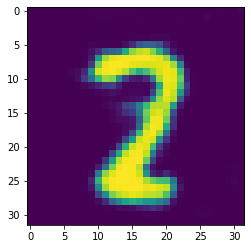

Discriminator out for this image: tensor([[0.0827]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 720
Discriminator loss: 0.20729443430900574
Generator loss: 9.815400838851929
Entering epoch no: 721
Discriminator loss: 0.5190201103687286
Generator loss: 9.153034687042236
Entering epoch no: 722
Discriminator loss: 0.24745894223451614
Generator loss: 9.87163257598877
Entering epoch no: 723
Discriminator loss: 0.08928027376532555
Generator loss: 10.59175443649292
Entering epoch no: 724
Discriminator loss: 0.36637747287750244
Generator loss: 10.869290590286255
Entering epoch no: 725
Discriminator loss: 0.11703390628099442
Generator loss: 10.354759454727173
Entering epoch no: 726
Discriminator loss: 0.2889021337032318
Generator loss: 10.750993251800537
Entering epoch no: 727
Discriminator loss: 0.2991754934191704
Generator loss: 10.122318267822266
Entering epoch no: 728
Discriminator loss: 0.20917708426713943
Generator loss: 10.25138235092163
Entering epoch no: 729
Discrim

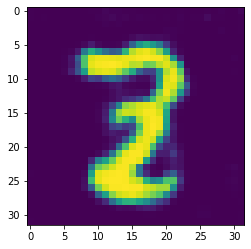

Discriminator out for this image: tensor([[0.0110]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 740
Discriminator loss: 0.6608808636665344
Generator loss: 8.332637310028076
Entering epoch no: 741
Discriminator loss: 0.8727213144302368
Generator loss: 8.205146312713623
Entering epoch no: 742
Discriminator loss: 0.2522962689399719
Generator loss: 7.857982873916626
Entering epoch no: 743
Discriminator loss: 0.49853551387786865
Generator loss: 8.337244033813477
Entering epoch no: 744
Discriminator loss: 0.30673249065876007
Generator loss: 9.913483381271362
Entering epoch no: 745
Discriminator loss: 0.542051151394844
Generator loss: 9.265305995941162
Entering epoch no: 746
Discriminator loss: 0.8281084895133972
Generator loss: 8.129067420959473
Entering epoch no: 747
Discriminator loss: 0.7219036519527435
Generator loss: 6.694030046463013
Entering epoch no: 748
Discriminator loss: 0.5066520124673843
Generator loss: 7.035900592803955
Entering epoch no: 749
Discriminator l

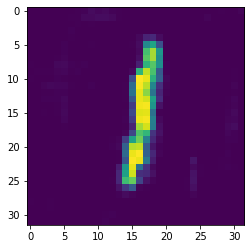

Discriminator out for this image: tensor([[0.1258]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 760
Discriminator loss: 0.32422739267349243
Generator loss: 10.975316762924194
Entering epoch no: 761
Discriminator loss: 0.5493398904800415
Generator loss: 9.723273992538452
Entering epoch no: 762
Discriminator loss: 0.4203812777996063
Generator loss: 8.02750539779663
Entering epoch no: 763
Discriminator loss: 0.36827242374420166
Generator loss: 8.034781694412231
Entering epoch no: 764
Discriminator loss: 0.36945709586143494
Generator loss: 7.233883857727051
Entering epoch no: 765
Discriminator loss: 0.30469849705696106
Generator loss: 7.979223251342773
Entering epoch no: 766
Discriminator loss: 0.1791246198117733
Generator loss: 8.710933446884155
Entering epoch no: 767
Discriminator loss: 0.310839019715786
Generator loss: 10.198752164840698
Entering epoch no: 768
Discriminator loss: 0.3722737282514572
Generator loss: 10.689336776733398
Entering epoch no: 769
Discriminat

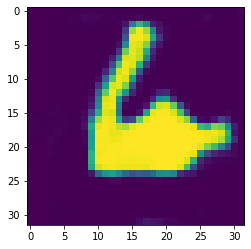

Discriminator out for this image: tensor([[0.0788]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 780
Discriminator loss: 0.23730725049972534
Generator loss: 10.901485919952393
Entering epoch no: 781
Discriminator loss: 0.3973400145769119
Generator loss: 9.756911754608154
Entering epoch no: 782
Discriminator loss: 0.2882251739501953
Generator loss: 10.690380334854126
Entering epoch no: 783
Discriminator loss: 0.2536565139889717
Generator loss: 8.496579885482788
Entering epoch no: 784
Discriminator loss: 0.29399029165506363
Generator loss: 8.853394746780396
Entering epoch no: 785
Discriminator loss: 0.3514344394207001
Generator loss: 8.272763013839722
Entering epoch no: 786
Discriminator loss: 0.2243618220090866
Generator loss: 8.255325078964233
Entering epoch no: 787
Discriminator loss: 0.4613182246685028
Generator loss: 8.63749074935913
Entering epoch no: 788
Discriminator loss: 0.6057031154632568
Generator loss: 9.25250792503357
Entering epoch no: 789
Discriminator 

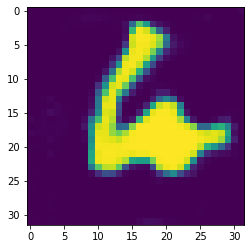

Discriminator out for this image: tensor([[0.2533]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 800
Discriminator loss: 0.3489408940076828
Generator loss: 8.572547912597656
Entering epoch no: 801
Discriminator loss: 0.4457717835903168
Generator loss: 9.858519554138184
Entering epoch no: 802
Discriminator loss: 0.2529507726430893
Generator loss: 10.164271116256714
Entering epoch no: 803
Discriminator loss: 0.2747665047645569
Generator loss: 9.830209016799927
Entering epoch no: 804
Discriminator loss: 0.42226171493530273
Generator loss: 11.045063257217407
Entering epoch no: 805
Discriminator loss: 0.46877357363700867
Generator loss: 9.005008459091187
Entering epoch no: 806
Discriminator loss: 0.5140769481658936
Generator loss: 7.85976505279541
Entering epoch no: 807
Discriminator loss: 0.2778448164463043
Generator loss: 7.49133563041687
Entering epoch no: 808
Discriminator loss: 0.23002491891384125
Generator loss: 8.783728837966919
Entering epoch no: 809
Discriminator

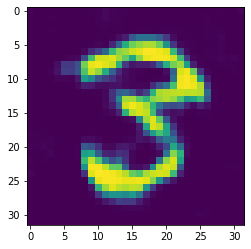

Discriminator out for this image: tensor([[0.0217]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 820
Discriminator loss: 0.23077649995684624
Generator loss: 8.827838659286499
Entering epoch no: 821
Discriminator loss: 0.1996334046125412
Generator loss: 10.642342567443848
Entering epoch no: 822
Discriminator loss: 0.6776541769504547
Generator loss: 9.594688892364502
Entering epoch no: 823
Discriminator loss: 0.277201883494854
Generator loss: 9.877683877944946
Entering epoch no: 824
Discriminator loss: 0.2453421801328659
Generator loss: 9.397976875305176
Entering epoch no: 825
Discriminator loss: 0.32844705879688263
Generator loss: 9.933019161224365
Entering epoch no: 826
Discriminator loss: 0.28952454030513763
Generator loss: 9.012975931167603
Entering epoch no: 827
Discriminator loss: 0.25263283401727676
Generator loss: 8.563668251037598
Entering epoch no: 828
Discriminator loss: 0.21866153925657272
Generator loss: 9.803270816802979
Entering epoch no: 829
Discriminat

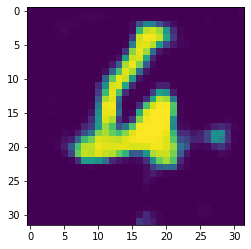

Discriminator out for this image: tensor([[0.0197]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 840
Discriminator loss: 0.30884476006031036
Generator loss: 9.789957761764526
Entering epoch no: 841
Discriminator loss: 0.3049279451370239
Generator loss: 10.220748662948608
Entering epoch no: 842
Discriminator loss: 0.2370787113904953
Generator loss: 9.637949705123901
Entering epoch no: 843
Discriminator loss: 0.14599577337503433
Generator loss: 9.110402822494507
Entering epoch no: 844
Discriminator loss: 0.26302482932806015
Generator loss: 8.546501636505127
Entering epoch no: 845
Discriminator loss: 0.19887175969779491
Generator loss: 9.997519969940186
Entering epoch no: 846
Discriminator loss: 0.200648695230484
Generator loss: 11.096755981445312
Entering epoch no: 847
Discriminator loss: 0.2321195974946022
Generator loss: 12.132655620574951
Entering epoch no: 848
Discriminator loss: 0.12942612916231155
Generator loss: 12.856770753860474
Entering epoch no: 849
Discrimi

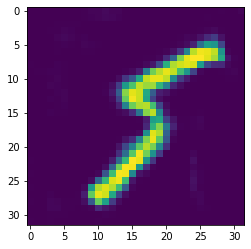

Discriminator out for this image: tensor([[0.0620]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 860
Discriminator loss: 0.24512264132499695
Generator loss: 7.646872043609619
Entering epoch no: 861
Discriminator loss: 0.26179980859160423
Generator loss: 7.505774974822998
Entering epoch no: 862
Discriminator loss: 0.5310686528682709
Generator loss: 8.201983213424683
Entering epoch no: 863
Discriminator loss: 0.23419246450066566
Generator loss: 8.400745868682861
Entering epoch no: 864
Discriminator loss: 0.5019273161888123
Generator loss: 9.546423435211182
Entering epoch no: 865
Discriminator loss: 0.270855113863945
Generator loss: 11.48196792602539
Entering epoch no: 866
Discriminator loss: 0.47720956802368164
Generator loss: 10.614274263381958
Entering epoch no: 867
Discriminator loss: 0.6721198260784149
Generator loss: 10.49885630607605
Entering epoch no: 868
Discriminator loss: 0.6634575128555298
Generator loss: 7.938395738601685
Entering epoch no: 869
Discriminato

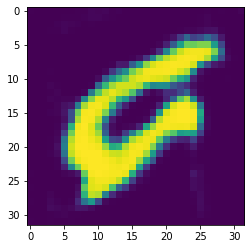

Discriminator out for this image: tensor([[0.1556]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 880
Discriminator loss: 0.39525561034679413
Generator loss: 7.729483366012573
Entering epoch no: 881
Discriminator loss: 0.48258237540721893
Generator loss: 9.333671808242798
Entering epoch no: 882
Discriminator loss: 0.43817466497421265
Generator loss: 9.531652688980103
Entering epoch no: 883
Discriminator loss: 0.32781367003917694
Generator loss: 10.525222301483154
Entering epoch no: 884
Discriminator loss: 0.660574346780777
Generator loss: 10.3569917678833
Entering epoch no: 885
Discriminator loss: 0.40559981763362885
Generator loss: 10.761067867279053
Entering epoch no: 886
Discriminator loss: 0.3073715567588806
Generator loss: 10.004195213317871
Entering epoch no: 887
Discriminator loss: 0.2539127543568611
Generator loss: 9.295910120010376
Entering epoch no: 888
Discriminator loss: 0.5091476887464523
Generator loss: 7.813283920288086
Entering epoch no: 889
Discrimina

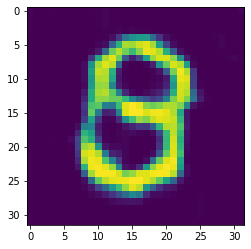

Discriminator out for this image: tensor([[0.0878]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 900
Discriminator loss: 0.4911150485277176
Generator loss: 7.907860994338989
Entering epoch no: 901
Discriminator loss: 0.5175914764404297
Generator loss: 7.795738697052002
Entering epoch no: 902
Discriminator loss: 0.2978571429848671
Generator loss: 8.787566900253296
Entering epoch no: 903
Discriminator loss: 0.23983263969421387
Generator loss: 8.923468589782715
Entering epoch no: 904
Discriminator loss: 0.3609880059957504
Generator loss: 9.208584308624268
Entering epoch no: 905
Discriminator loss: 0.34685902297496796
Generator loss: 9.698408603668213
Entering epoch no: 906
Discriminator loss: 0.3013581186532974
Generator loss: 11.227468967437744
Entering epoch no: 907
Discriminator loss: 0.4434737265110016
Generator loss: 10.097433090209961
Entering epoch no: 908
Discriminator loss: 0.6880893111228943
Generator loss: 7.9614317417144775
Entering epoch no: 909
Discriminat

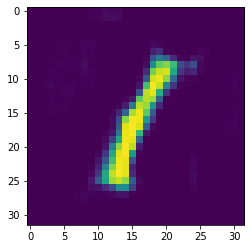

Discriminator out for this image: tensor([[0.2112]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 920
Discriminator loss: 0.25642508268356323
Generator loss: 8.405147314071655
Entering epoch no: 921
Discriminator loss: 0.42836007475852966
Generator loss: 8.433289766311646
Entering epoch no: 922
Discriminator loss: 0.6943328380584717
Generator loss: 7.028198003768921
Entering epoch no: 923
Discriminator loss: 0.4783834367990494
Generator loss: 6.346380233764648
Entering epoch no: 924
Discriminator loss: 0.5348878651857376
Generator loss: 8.524980545043945
Entering epoch no: 925
Discriminator loss: 0.2601965442299843
Generator loss: 10.123156547546387
Entering epoch no: 926
Discriminator loss: 0.6135246455669403
Generator loss: 10.531662225723267
Entering epoch no: 927
Discriminator loss: 0.588064581155777
Generator loss: 10.397335052490234
Entering epoch no: 928
Discriminator loss: 0.5825373232364655
Generator loss: 9.326961278915405
Entering epoch no: 929
Discriminato

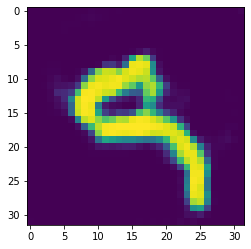

Discriminator out for this image: tensor([[0.2704]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 940
Discriminator loss: 0.4895247519016266
Generator loss: 5.99553120136261
Entering epoch no: 941
Discriminator loss: 0.45810477435588837
Generator loss: 6.094731092453003
Entering epoch no: 942
Discriminator loss: 0.4064784273505211
Generator loss: 7.205842733383179
Entering epoch no: 943
Discriminator loss: 0.5330231189727783
Generator loss: 9.423489809036255
Entering epoch no: 944
Discriminator loss: 0.4960850328207016
Generator loss: 10.087743282318115
Entering epoch no: 945
Discriminator loss: 0.8356620669364929
Generator loss: 10.8721604347229
Entering epoch no: 946
Discriminator loss: 0.9488222599029541
Generator loss: 10.16147255897522
Entering epoch no: 947
Discriminator loss: 0.927827000617981
Generator loss: 7.517014503479004
Entering epoch no: 948
Discriminator loss: 0.4324643909931183
Generator loss: 5.624593496322632
Entering epoch no: 949
Discriminator los

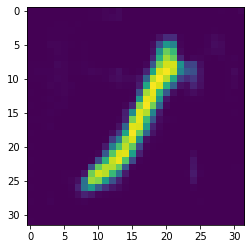

Discriminator out for this image: tensor([[0.0789]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 960
Discriminator loss: 0.43512724339962006
Generator loss: 9.865706205368042
Entering epoch no: 961
Discriminator loss: 0.8150544762611389
Generator loss: 10.13596510887146
Entering epoch no: 962
Discriminator loss: 0.5950986444950104
Generator loss: 9.48009204864502
Entering epoch no: 963
Discriminator loss: 0.4659072756767273
Generator loss: 8.476584196090698
Entering epoch no: 964
Discriminator loss: 0.5051481425762177
Generator loss: 7.142805576324463
Entering epoch no: 965
Discriminator loss: 0.42240259051322937
Generator loss: 7.306257486343384
Entering epoch no: 966
Discriminator loss: 0.5669337958097458
Generator loss: 6.469763994216919
Entering epoch no: 967
Discriminator loss: 0.40088996291160583
Generator loss: 7.362887382507324
Entering epoch no: 968
Discriminator loss: 0.4994278848171234
Generator loss: 8.901708364486694
Entering epoch no: 969
Discriminator 

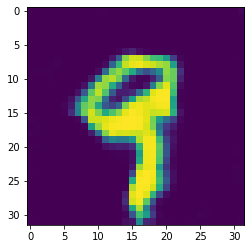

Discriminator out for this image: tensor([[0.0974]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 980
Discriminator loss: 0.6585300862789154
Generator loss: 8.708379745483398
Entering epoch no: 981
Discriminator loss: 0.4132913202047348
Generator loss: 8.621402978897095
Entering epoch no: 982
Discriminator loss: 0.613845705986023
Generator loss: 7.313385963439941
Entering epoch no: 983
Discriminator loss: 0.4572058618068695
Generator loss: 6.950631618499756
Entering epoch no: 984
Discriminator loss: 0.4407840296626091
Generator loss: 8.195823669433594
Entering epoch no: 985
Discriminator loss: 0.3601534962654114
Generator loss: 8.797065734863281
Entering epoch no: 986
Discriminator loss: 0.38542261719703674
Generator loss: 10.85208797454834
Entering epoch no: 987
Discriminator loss: 0.49957965314388275
Generator loss: 11.04543161392212
Entering epoch no: 988
Discriminator loss: 0.45424747467041016
Generator loss: 11.889233112335205
Entering epoch no: 989
Discriminator

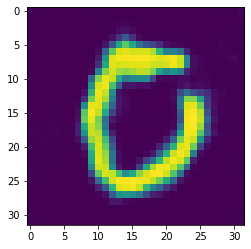

Discriminator out for this image: tensor([[0.0857]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1000
Discriminator loss: 0.5008712708950043
Generator loss: 9.284197568893433
Entering epoch no: 1001
Discriminator loss: 0.8585649728775024
Generator loss: 9.569236755371094
Entering epoch no: 1002
Discriminator loss: 0.6148265600204468
Generator loss: 8.01164960861206
Entering epoch no: 1003
Discriminator loss: 0.4461534023284912
Generator loss: 8.671247720718384
Entering epoch no: 1004
Discriminator loss: 0.8204714357852936
Generator loss: 7.3566179275512695
Entering epoch no: 1005
Discriminator loss: 0.8173826336860657
Generator loss: 7.192011833190918
Entering epoch no: 1006
Discriminator loss: 0.9641317129135132
Generator loss: 8.219496250152588
Entering epoch no: 1007
Discriminator loss: 0.6308941543102264
Generator loss: 8.771888256072998
Entering epoch no: 1008
Discriminator loss: 0.5430655777454376
Generator loss: 7.97363543510437
Entering epoch no: 1009
Discrim

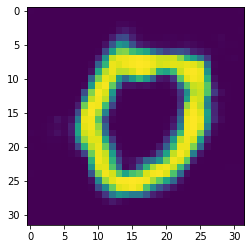

Discriminator out for this image: tensor([[0.1746]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1020
Discriminator loss: 0.5109403133392334
Generator loss: 7.282923936843872
Entering epoch no: 1021
Discriminator loss: 0.45185500383377075
Generator loss: 6.664678335189819
Entering epoch no: 1022
Discriminator loss: 0.3374383896589279
Generator loss: 8.004066705703735
Entering epoch no: 1023
Discriminator loss: 0.26737404614686966
Generator loss: 10.19282841682434
Entering epoch no: 1024
Discriminator loss: 0.8703907132148743
Generator loss: 10.429940462112427
Entering epoch no: 1025
Discriminator loss: 0.3800567239522934
Generator loss: 9.784334659576416
Entering epoch no: 1026
Discriminator loss: 0.5959708392620087
Generator loss: 8.73534631729126
Entering epoch no: 1027
Discriminator loss: 0.3120103180408478
Generator loss: 8.163107633590698
Entering epoch no: 1028
Discriminator loss: 0.44542959332466125
Generator loss: 8.291637420654297
Entering epoch no: 1029
Dis

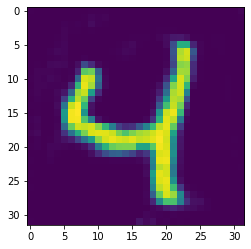

Discriminator out for this image: tensor([[0.1448]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1040
Discriminator loss: 0.4359021335840225
Generator loss: 8.886647462844849
Entering epoch no: 1041
Discriminator loss: 0.6113487780094147
Generator loss: 9.969760179519653
Entering epoch no: 1042
Discriminator loss: 0.4744154214859009
Generator loss: 9.330164670944214
Entering epoch no: 1043
Discriminator loss: 0.44313132762908936
Generator loss: 10.477400064468384
Entering epoch no: 1044
Discriminator loss: 0.3672337830066681
Generator loss: 8.902304887771606
Entering epoch no: 1045
Discriminator loss: 0.519777774810791
Generator loss: 9.342696189880371
Entering epoch no: 1046
Discriminator loss: 0.35343262553215027
Generator loss: 8.571723461151123
Entering epoch no: 1047
Discriminator loss: 0.6759600043296814
Generator loss: 7.594627141952515
Entering epoch no: 1048
Discriminator loss: 0.4752899408340454
Generator loss: 6.811470985412598
Entering epoch no: 1049
Disc

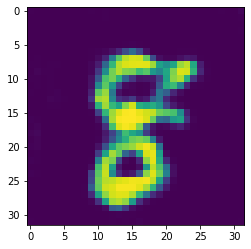

Discriminator out for this image: tensor([[0.1009]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1060
Discriminator loss: 0.22152391076087952
Generator loss: 10.047273635864258
Entering epoch no: 1061
Discriminator loss: 0.35859449207782745
Generator loss: 11.238424301147461
Entering epoch no: 1062
Discriminator loss: 0.32485949993133545
Generator loss: 10.324495077133179
Entering epoch no: 1063
Discriminator loss: 0.34478147327899933
Generator loss: 10.495423793792725
Entering epoch no: 1064
Discriminator loss: 0.24829812347888947
Generator loss: 11.100712776184082
Entering epoch no: 1065
Discriminator loss: 0.22034119814634323
Generator loss: 10.973295450210571
Entering epoch no: 1066
Discriminator loss: 0.23599593341350555
Generator loss: 11.798064470291138
Entering epoch no: 1067
Discriminator loss: 0.34021539986133575
Generator loss: 10.212133407592773
Entering epoch no: 1068
Discriminator loss: 0.5722706466913223
Generator loss: 9.474320411682129
Entering epoch

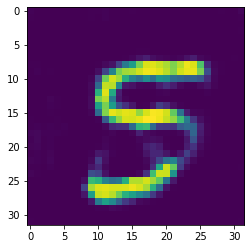

Discriminator out for this image: tensor([[0.1238]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1080
Discriminator loss: 0.30745191127061844
Generator loss: 8.773048400878906
Entering epoch no: 1081
Discriminator loss: 0.31173793971538544
Generator loss: 9.976261377334595
Entering epoch no: 1082
Discriminator loss: 0.35178038477897644
Generator loss: 10.263362884521484
Entering epoch no: 1083
Discriminator loss: 0.41673532128334045
Generator loss: 10.42668080329895
Entering epoch no: 1084
Discriminator loss: 0.3150235116481781
Generator loss: 9.464452505111694
Entering epoch no: 1085
Discriminator loss: 0.1731574833393097
Generator loss: 10.626162052154541
Entering epoch no: 1086
Discriminator loss: 0.17970693483948708
Generator loss: 9.535943269729614
Entering epoch no: 1087
Discriminator loss: 0.2546360567212105
Generator loss: 10.106032848358154
Entering epoch no: 1088
Discriminator loss: 0.41577185690402985
Generator loss: 10.522144794464111
Entering epoch no: 1

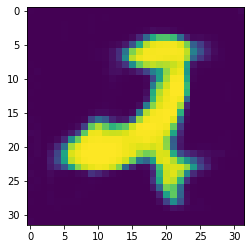

Discriminator out for this image: tensor([[0.3136]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1100
Discriminator loss: 0.19733229279518127
Generator loss: 9.535794258117676
Entering epoch no: 1101
Discriminator loss: 0.21883421391248703
Generator loss: 9.338524341583252
Entering epoch no: 1102
Discriminator loss: 0.15997152030467987
Generator loss: 8.88937520980835
Entering epoch no: 1103
Discriminator loss: 0.1578095220029354
Generator loss: 8.861460447311401
Entering epoch no: 1104
Discriminator loss: 0.23651035130023956
Generator loss: 9.3870849609375
Entering epoch no: 1105
Discriminator loss: 0.24098506569862366
Generator loss: 9.610406637191772
Entering epoch no: 1106
Discriminator loss: 0.29380518943071365
Generator loss: 9.396360397338867
Entering epoch no: 1107
Discriminator loss: 0.2613057717680931
Generator loss: 9.361596822738647
Entering epoch no: 1108
Discriminator loss: 0.32780009508132935
Generator loss: 11.92772388458252
Entering epoch no: 1109
Di

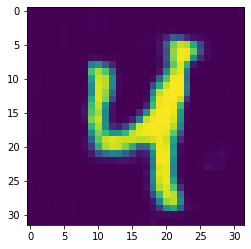

Discriminator out for this image: tensor([[0.0916]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1120
Discriminator loss: 0.3311360478401184
Generator loss: 7.808102369308472
Entering epoch no: 1121
Discriminator loss: 0.2718826234340668
Generator loss: 8.30885100364685
Entering epoch no: 1122
Discriminator loss: 0.23273928463459015
Generator loss: 8.132200717926025
Entering epoch no: 1123
Discriminator loss: 0.30377908051013947
Generator loss: 8.595689296722412
Entering epoch no: 1124
Discriminator loss: 0.3701784908771515
Generator loss: 11.817023754119873
Entering epoch no: 1125
Discriminator loss: 0.24495793879032135
Generator loss: 11.180406332015991
Entering epoch no: 1126
Discriminator loss: 0.18462619930505753
Generator loss: 12.013811588287354
Entering epoch no: 1127
Discriminator loss: 0.16709056869149208
Generator loss: 11.989858150482178
Entering epoch no: 1128
Discriminator loss: 0.3686210960149765
Generator loss: 11.799922227859497
Entering epoch no: 11

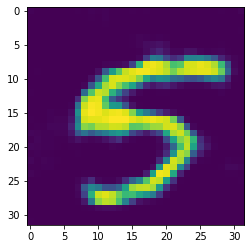

Discriminator out for this image: tensor([[0.2163]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1140
Discriminator loss: 0.27385756373405457
Generator loss: 6.002424001693726
Entering epoch no: 1141
Discriminator loss: 0.18662394769489765
Generator loss: 6.737640738487244
Entering epoch no: 1142
Discriminator loss: 0.28608872927725315
Generator loss: 8.842241048812866
Entering epoch no: 1143
Discriminator loss: 0.23453281819820404
Generator loss: 10.181647300720215
Entering epoch no: 1144
Discriminator loss: 0.26253965497016907
Generator loss: 12.944391250610352
Entering epoch no: 1145
Discriminator loss: 0.20723579078912735
Generator loss: 15.409937381744385
Entering epoch no: 1146
Discriminator loss: 0.4919935613870621
Generator loss: 13.458312034606934
Entering epoch no: 1147
Discriminator loss: 0.3923325836658478
Generator loss: 12.669354677200317
Entering epoch no: 1148
Discriminator loss: 0.49712593853473663
Generator loss: 10.848097085952759
Entering epoch no

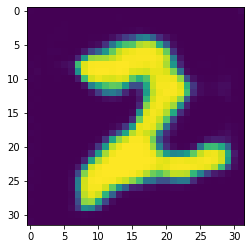

Discriminator out for this image: tensor([[0.5068]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1160
Discriminator loss: 0.1186398770660162
Generator loss: 6.570634841918945
Entering epoch no: 1161
Discriminator loss: 0.4184580147266388
Generator loss: 7.553617477416992
Entering epoch no: 1162
Discriminator loss: 0.1690276712179184
Generator loss: 9.232314348220825
Entering epoch no: 1163
Discriminator loss: 0.4279737323522568
Generator loss: 9.668206214904785
Entering epoch no: 1164
Discriminator loss: 0.22269119322299957
Generator loss: 10.92741060256958
Entering epoch no: 1165
Discriminator loss: 0.7594608664512634
Generator loss: 11.686004400253296
Entering epoch no: 1166
Discriminator loss: 0.32771506905555725
Generator loss: 10.2856285572052
Entering epoch no: 1167
Discriminator loss: 0.17525572702288628
Generator loss: 9.548617601394653
Entering epoch no: 1168
Discriminator loss: 0.401100754737854
Generator loss: 9.116911888122559
Entering epoch no: 1169
Disc

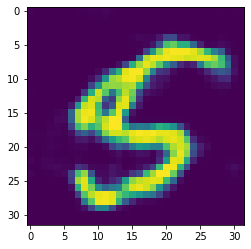

Discriminator out for this image: tensor([[0.0449]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1180
Discriminator loss: 0.23635008931159973
Generator loss: 10.898252010345459
Entering epoch no: 1181
Discriminator loss: 0.32623329758644104
Generator loss: 9.92923092842102
Entering epoch no: 1182
Discriminator loss: 0.5125937014818192
Generator loss: 9.471676349639893
Entering epoch no: 1183
Discriminator loss: 0.3807733952999115
Generator loss: 10.451378107070923
Entering epoch no: 1184
Discriminator loss: 0.4413387179374695
Generator loss: 10.03108286857605
Entering epoch no: 1185
Discriminator loss: 0.275818407535553
Generator loss: 8.83638620376587
Entering epoch no: 1186
Discriminator loss: 0.29642949253320694
Generator loss: 9.84646201133728
Entering epoch no: 1187
Discriminator loss: 0.21956657618284225
Generator loss: 10.141374111175537
Entering epoch no: 1188
Discriminator loss: 0.14670519530773163
Generator loss: 10.551650285720825
Entering epoch no: 1189
D

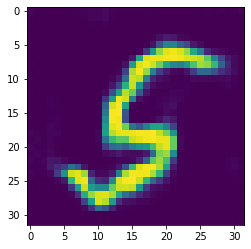

Discriminator out for this image: tensor([[0.1450]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1200
Discriminator loss: 0.21143081784248352
Generator loss: 9.119763612747192
Entering epoch no: 1201
Discriminator loss: 0.17545222491025925
Generator loss: 10.27465558052063
Entering epoch no: 1202
Discriminator loss: 0.27333925664424896
Generator loss: 11.412237405776978
Entering epoch no: 1203
Discriminator loss: 0.34808051586151123
Generator loss: 10.885605573654175
Entering epoch no: 1204
Discriminator loss: 0.18581843376159668
Generator loss: 11.22194528579712
Entering epoch no: 1205
Discriminator loss: 0.2162039428949356
Generator loss: 11.868473768234253
Entering epoch no: 1206
Discriminator loss: 0.28040725737810135
Generator loss: 11.10537052154541
Entering epoch no: 1207
Discriminator loss: 0.18468307703733444
Generator loss: 10.95339560508728
Entering epoch no: 1208
Discriminator loss: 0.3255631923675537
Generator loss: 10.052340984344482
Entering epoch no: 

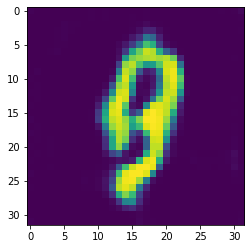

Discriminator out for this image: tensor([[0.0728]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1220
Discriminator loss: 0.30130472779273987
Generator loss: 10.7495436668396
Entering epoch no: 1221
Discriminator loss: 0.2975207418203354
Generator loss: 11.03809928894043
Entering epoch no: 1222
Discriminator loss: 0.3596509099006653
Generator loss: 10.256793022155762
Entering epoch no: 1223
Discriminator loss: 0.22744525969028473
Generator loss: 9.98831033706665
Entering epoch no: 1224
Discriminator loss: 0.3284538984298706
Generator loss: 9.700100898742676
Entering epoch no: 1225
Discriminator loss: 0.4115816801786423
Generator loss: 7.947114706039429
Entering epoch no: 1226
Discriminator loss: 0.5263312458992004
Generator loss: 8.537330150604248
Entering epoch no: 1227
Discriminator loss: 0.32247405499219894
Generator loss: 7.449884414672852
Entering epoch no: 1228
Discriminator loss: 0.37829187512397766
Generator loss: 6.593957185745239
Entering epoch no: 1229
Dis

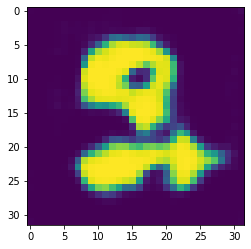

Discriminator out for this image: tensor([[0.0782]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1240
Discriminator loss: 0.4045671224594116
Generator loss: 8.792054891586304
Entering epoch no: 1241
Discriminator loss: 0.4735916703939438
Generator loss: 8.383334636688232
Entering epoch no: 1242
Discriminator loss: 0.5589970797300339
Generator loss: 8.714879035949707
Entering epoch no: 1243
Discriminator loss: 0.36580051481723785
Generator loss: 9.03945779800415
Entering epoch no: 1244
Discriminator loss: 0.36254146695137024
Generator loss: 8.325973272323608
Entering epoch no: 1245
Discriminator loss: 0.6042178869247437
Generator loss: 8.188837766647339
Entering epoch no: 1246
Discriminator loss: 0.44113102555274963
Generator loss: 9.417392492294312
Entering epoch no: 1247
Discriminator loss: 0.4939727187156677
Generator loss: 8.958771228790283
Entering epoch no: 1248
Discriminator loss: 0.4053448587656021
Generator loss: 7.858974933624268
Entering epoch no: 1249
Disc

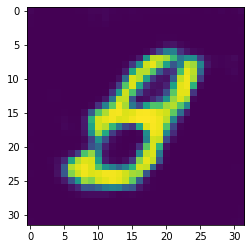

Discriminator out for this image: tensor([[0.1946]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1260
Discriminator loss: 0.34734123945236206
Generator loss: 9.219949722290039
Entering epoch no: 1261
Discriminator loss: 0.503975510597229
Generator loss: 9.941150188446045
Entering epoch no: 1262
Discriminator loss: 0.33560778200626373
Generator loss: 12.301630973815918
Entering epoch no: 1263
Discriminator loss: 0.6770403683185577
Generator loss: 12.284335136413574
Entering epoch no: 1264
Discriminator loss: 0.48734575510025024
Generator loss: 10.733903884887695
Entering epoch no: 1265
Discriminator loss: 1.229496955871582
Generator loss: 8.065916776657104
Entering epoch no: 1266
Discriminator loss: 0.497742623090744
Generator loss: 6.128665447235107
Entering epoch no: 1267
Discriminator loss: 0.5610986351966858
Generator loss: 7.2364490032196045
Entering epoch no: 1268
Discriminator loss: 0.659465491771698
Generator loss: 8.37590217590332
Entering epoch no: 1269
Disc

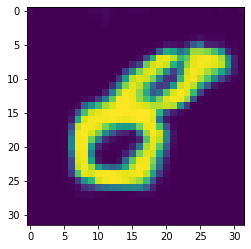

Discriminator out for this image: tensor([[0.0965]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1280
Discriminator loss: 0.3604007512331009
Generator loss: 9.641885757446289
Entering epoch no: 1281
Discriminator loss: 0.31878355890512466
Generator loss: 9.789694786071777
Entering epoch no: 1282
Discriminator loss: 0.23572682589292526
Generator loss: 10.732171297073364
Entering epoch no: 1283
Discriminator loss: 0.2142448127269745
Generator loss: 10.503557682037354
Entering epoch no: 1284
Discriminator loss: 0.40368057787418365
Generator loss: 10.325490713119507
Entering epoch no: 1285
Discriminator loss: 0.33956846594810486
Generator loss: 10.513627767562866
Entering epoch no: 1286
Discriminator loss: 0.13720184564590454
Generator loss: 10.269845485687256
Entering epoch no: 1287
Discriminator loss: 0.1439905297011137
Generator loss: 10.896745681762695
Entering epoch no: 1288
Discriminator loss: 0.355460450053215
Generator loss: 11.863433361053467
Entering epoch no: 

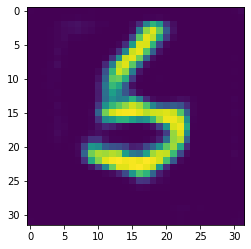

Discriminator out for this image: tensor([[0.0463]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1300
Discriminator loss: 0.2957855314016342
Generator loss: 13.736722946166992
Entering epoch no: 1301
Discriminator loss: 0.40682512521743774
Generator loss: 12.774402618408203
Entering epoch no: 1302
Discriminator loss: 0.2574969083070755
Generator loss: 12.235049724578857
Entering epoch no: 1303
Discriminator loss: 0.20094730705022812
Generator loss: 11.23707365989685
Entering epoch no: 1304
Discriminator loss: 0.2561492249369621
Generator loss: 9.610371828079224
Entering epoch no: 1305
Discriminator loss: 0.1692427136003971
Generator loss: 8.439085245132446
Entering epoch no: 1306
Discriminator loss: 0.2140754796564579
Generator loss: 8.383936405181885
Entering epoch no: 1307
Discriminator loss: 0.23128216713666916
Generator loss: 9.492701292037964
Entering epoch no: 1308
Discriminator loss: 0.27921774983406067
Generator loss: 10.614532470703125
Entering epoch no: 130

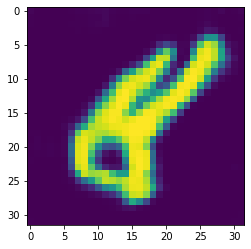

Discriminator out for this image: tensor([[0.0144]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1320
Discriminator loss: 0.2870156019926071
Generator loss: 10.958763599395752
Entering epoch no: 1321
Discriminator loss: 0.2105223312973976
Generator loss: 10.913450002670288
Entering epoch no: 1322
Discriminator loss: 0.16096651181578636
Generator loss: 10.0940580368042
Entering epoch no: 1323
Discriminator loss: 0.1793680638074875
Generator loss: 10.390920162200928
Entering epoch no: 1324
Discriminator loss: 0.4325987845659256
Generator loss: 9.733289003372192
Entering epoch no: 1325
Discriminator loss: 0.1325139682739973
Generator loss: 9.126155614852905
Entering epoch no: 1326
Discriminator loss: 0.23985555768013
Generator loss: 10.259491682052612
Entering epoch no: 1327
Discriminator loss: 0.2244827002286911
Generator loss: 10.247713804244995
Entering epoch no: 1328
Discriminator loss: 0.21802039444446564
Generator loss: 10.80573558807373
Entering epoch no: 1329
Di

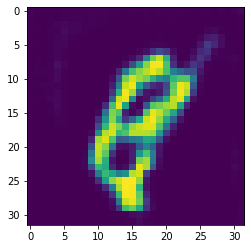

Discriminator out for this image: tensor([[0.0926]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1340
Discriminator loss: 0.2892986536026001
Generator loss: 8.870261192321777
Entering epoch no: 1341
Discriminator loss: 0.4975161552429199
Generator loss: 8.856838703155518
Entering epoch no: 1342
Discriminator loss: 0.3588706851005554
Generator loss: 9.588378429412842
Entering epoch no: 1343
Discriminator loss: 0.5550719797611237
Generator loss: 8.743189334869385
Entering epoch no: 1344
Discriminator loss: 0.4283156096935272
Generator loss: 9.416053295135498
Entering epoch no: 1345
Discriminator loss: 0.40946903824806213
Generator loss: 9.335850954055786
Entering epoch no: 1346
Discriminator loss: 0.38632121682167053
Generator loss: 9.608348608016968
Entering epoch no: 1347
Discriminator loss: 0.486361026763916
Generator loss: 8.452697277069092
Entering epoch no: 1348
Discriminator loss: 0.34382183849811554
Generator loss: 9.28106141090393
Entering epoch no: 1349
Discr

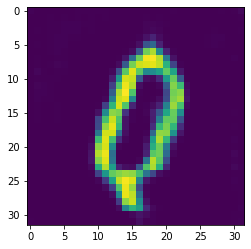

Discriminator out for this image: tensor([[0.0499]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1360
Discriminator loss: 0.16531329602003098
Generator loss: 9.889578819274902
Entering epoch no: 1361
Discriminator loss: 0.13148459792137146
Generator loss: 10.805551290512085
Entering epoch no: 1362
Discriminator loss: 0.18159837275743484
Generator loss: 10.551713943481445
Entering epoch no: 1363
Discriminator loss: 0.14241725206375122
Generator loss: 11.931455373764038
Entering epoch no: 1364
Discriminator loss: 0.1273602545261383
Generator loss: 11.63296127319336
Entering epoch no: 1365
Discriminator loss: 0.1840587481856346
Generator loss: 11.017592668533325
Entering epoch no: 1366
Discriminator loss: 0.2643159553408623
Generator loss: 10.732187509536743
Entering epoch no: 1367
Discriminator loss: 0.2190466672182083
Generator loss: 11.34483814239502
Entering epoch no: 1368
Discriminator loss: 0.08677022717893124
Generator loss: 10.068789720535278
Entering epoch no: 

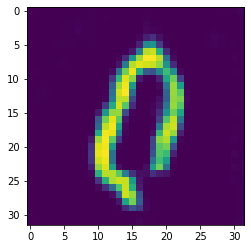

Discriminator out for this image: tensor([[0.0699]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1380
Discriminator loss: 0.11916184797883034
Generator loss: 10.685388565063477
Entering epoch no: 1381
Discriminator loss: 0.17506907880306244
Generator loss: 10.30267882347107
Entering epoch no: 1382
Discriminator loss: 0.2653399556875229
Generator loss: 10.098197937011719
Entering epoch no: 1383
Discriminator loss: 0.23606149852275848
Generator loss: 9.035326957702637
Entering epoch no: 1384
Discriminator loss: 0.18812917172908783
Generator loss: 9.624465703964233
Entering epoch no: 1385
Discriminator loss: 0.16648884862661362
Generator loss: 9.314115524291992
Entering epoch no: 1386
Discriminator loss: 0.20784135162830353
Generator loss: 9.152737140655518
Entering epoch no: 1387
Discriminator loss: 0.23544901609420776
Generator loss: 9.661603927612305
Entering epoch no: 1388
Discriminator loss: 0.27018172293901443
Generator loss: 10.852484941482544
Entering epoch no: 

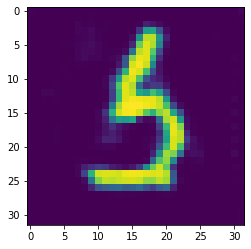

Discriminator out for this image: tensor([[0.1281]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1400
Discriminator loss: 0.18324005231261253
Generator loss: 11.027082920074463
Entering epoch no: 1401
Discriminator loss: 0.35705485939979553
Generator loss: 12.573974847793579
Entering epoch no: 1402
Discriminator loss: 0.23042970895767212
Generator loss: 12.826632976531982
Entering epoch no: 1403
Discriminator loss: 0.27967362105846405
Generator loss: 13.039141654968262
Entering epoch no: 1404
Discriminator loss: 0.39064884185791016
Generator loss: 12.081364870071411
Entering epoch no: 1405
Discriminator loss: 0.48796670138835907
Generator loss: 11.051375150680542
Entering epoch no: 1406
Discriminator loss: 0.2967342734336853
Generator loss: 8.923712730407715
Entering epoch no: 1407
Discriminator loss: 0.3693360239267349
Generator loss: 7.605937719345093
Entering epoch no: 1408
Discriminator loss: 0.48260796070098877
Generator loss: 7.510724306106567
Entering epoch no

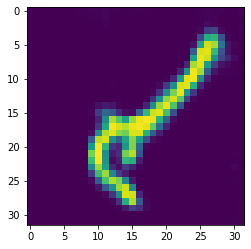

Discriminator out for this image: tensor([[0.2524]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1420
Discriminator loss: 0.3451489359140396
Generator loss: 7.392342567443848
Entering epoch no: 1421
Discriminator loss: 0.24710439890623093
Generator loss: 9.126984596252441
Entering epoch no: 1422
Discriminator loss: 0.27550915628671646
Generator loss: 12.79416561126709
Entering epoch no: 1423
Discriminator loss: 0.3099808096885681
Generator loss: 14.616501808166504
Entering epoch no: 1424
Discriminator loss: 0.18127597123384476
Generator loss: 16.033926486968994
Entering epoch no: 1425
Discriminator loss: 0.19642844796180725
Generator loss: 16.79087495803833
Entering epoch no: 1426
Discriminator loss: 0.3704838752746582
Generator loss: 15.752338886260986
Entering epoch no: 1427
Discriminator loss: 0.3077050745487213
Generator loss: 14.444825649261475
Entering epoch no: 1428
Discriminator loss: 0.15940628945827484
Generator loss: 13.879104137420654
Entering epoch no: 1

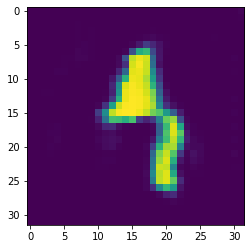

Discriminator out for this image: tensor([[0.0290]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1440
Discriminator loss: 0.3837418556213379
Generator loss: 12.910749435424805
Entering epoch no: 1441
Discriminator loss: 0.1563618779182434
Generator loss: 11.390685081481934
Entering epoch no: 1442
Discriminator loss: 0.2687465250492096
Generator loss: 10.21498966217041
Entering epoch no: 1443
Discriminator loss: 0.5054079443216324
Generator loss: 8.674590110778809
Entering epoch no: 1444
Discriminator loss: 0.30116550624370575
Generator loss: 8.192401885986328
Entering epoch no: 1445
Discriminator loss: 0.17248595505952835
Generator loss: 7.648051738739014
Entering epoch no: 1446
Discriminator loss: 0.2930848151445389
Generator loss: 7.584638357162476
Entering epoch no: 1447
Discriminator loss: 0.2508123070001602
Generator loss: 9.596729278564453
Entering epoch no: 1448
Discriminator loss: 0.17021897435188293
Generator loss: 11.005622148513794
Entering epoch no: 1449


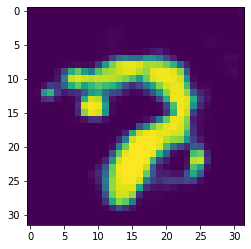

Discriminator out for this image: tensor([[0.0304]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1460
Discriminator loss: 0.08067067712545395
Generator loss: 10.516381978988647
Entering epoch no: 1461
Discriminator loss: 0.08368626981973648
Generator loss: 10.729727506637573
Entering epoch no: 1462
Discriminator loss: 0.0879448801279068
Generator loss: 12.193665981292725
Entering epoch no: 1463
Discriminator loss: 0.10090531036257744
Generator loss: 12.712960243225098
Entering epoch no: 1464
Discriminator loss: 0.1849222034215927
Generator loss: 12.3792724609375
Entering epoch no: 1465
Discriminator loss: 0.0556327011436224
Generator loss: 14.242547035217285
Entering epoch no: 1466
Discriminator loss: 0.177038311958313
Generator loss: 14.254797458648682
Entering epoch no: 1467
Discriminator loss: 0.05998559296131134
Generator loss: 14.15365982055664
Entering epoch no: 1468
Discriminator loss: 0.08659430593252182
Generator loss: 12.85480785369873
Entering epoch no: 14

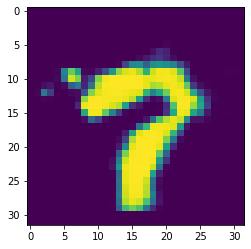

Discriminator out for this image: tensor([[0.0157]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1480
Discriminator loss: 0.16121717542409897
Generator loss: 14.616987705230713
Entering epoch no: 1481
Discriminator loss: 0.07011358812451363
Generator loss: 15.01187515258789
Entering epoch no: 1482
Discriminator loss: 0.1950601190328598
Generator loss: 13.463711261749268
Entering epoch no: 1483
Discriminator loss: 0.27108313888311386
Generator loss: 13.571890592575073
Entering epoch no: 1484
Discriminator loss: 0.09205296635627747
Generator loss: 11.92384123802185
Entering epoch no: 1485
Discriminator loss: 0.13584496453404427
Generator loss: 11.911214590072632
Entering epoch no: 1486
Discriminator loss: 0.16349753364920616
Generator loss: 10.166975975036621
Entering epoch no: 1487
Discriminator loss: 0.062044477090239525
Generator loss: 10.822457790374756
Entering epoch no: 1488
Discriminator loss: 0.08734879270195961
Generator loss: 10.138739109039307
Entering epoch

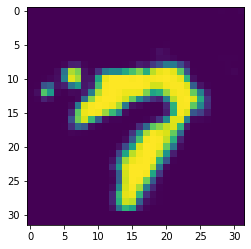

Discriminator out for this image: tensor([[0.2103]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1500
Discriminator loss: 0.29112324863672256
Generator loss: 8.496628999710083
Entering epoch no: 1501
Discriminator loss: 0.28443726897239685
Generator loss: 12.52790355682373
Entering epoch no: 1502
Discriminator loss: 0.2932778671383858
Generator loss: 13.057962417602539
Entering epoch no: 1503
Discriminator loss: 0.12964601442217827
Generator loss: 14.274991512298584
Entering epoch no: 1504
Discriminator loss: 0.1645701676607132
Generator loss: 14.877694606781006
Entering epoch no: 1505
Discriminator loss: 0.362046554684639
Generator loss: 14.007251739501953
Entering epoch no: 1506
Discriminator loss: 0.26486973464488983
Generator loss: 12.151339530944824
Entering epoch no: 1507
Discriminator loss: 0.10160565376281738
Generator loss: 11.60804295539856
Entering epoch no: 1508
Discriminator loss: 0.14469683170318604
Generator loss: 10.921215534210205
Entering epoch no: 

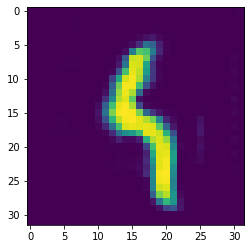

Discriminator out for this image: tensor([[0.0190]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1520
Discriminator loss: 0.06391618214547634
Generator loss: 13.572685241699219
Entering epoch no: 1521
Discriminator loss: 0.12863140553236008
Generator loss: 14.872744083404541
Entering epoch no: 1522
Discriminator loss: 0.0495979655534029
Generator loss: 14.738532066345215
Entering epoch no: 1523
Discriminator loss: 0.10454224795103073
Generator loss: 13.87623643875122
Entering epoch no: 1524
Discriminator loss: 0.19499944895505905
Generator loss: 13.311009645462036
Entering epoch no: 1525
Discriminator loss: 0.10031466744840145
Generator loss: 12.72022008895874
Entering epoch no: 1526
Discriminator loss: 0.06575479917228222
Generator loss: 13.501518726348877
Entering epoch no: 1527
Discriminator loss: 0.06398122198879719
Generator loss: 13.650150299072266
Entering epoch no: 1528
Discriminator loss: 0.08811361901462078
Generator loss: 13.288580894470215
Entering epoch 

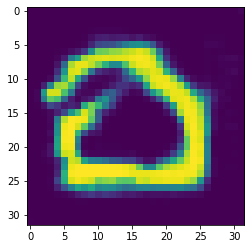

Discriminator out for this image: tensor([[0.0042]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1540
Discriminator loss: 0.16051173210144043
Generator loss: 13.525575637817383
Entering epoch no: 1541
Discriminator loss: 0.20702585577964783
Generator loss: 13.656550884246826
Entering epoch no: 1542
Discriminator loss: 0.18962488323450089
Generator loss: 11.645817756652832
Entering epoch no: 1543
Discriminator loss: 0.07145515084266663
Generator loss: 12.627020835876465
Entering epoch no: 1544
Discriminator loss: 0.07228901796042919
Generator loss: 12.133113145828247
Entering epoch no: 1545
Discriminator loss: 0.20937440544366837
Generator loss: 12.927695751190186
Entering epoch no: 1546
Discriminator loss: 0.09413482248783112
Generator loss: 10.4148530960083
Entering epoch no: 1547
Discriminator loss: 0.056673677172511816
Generator loss: 11.537121772766113
Entering epoch no: 1548
Discriminator loss: 0.21314193308353424
Generator loss: 11.180854558944702
Entering epoc

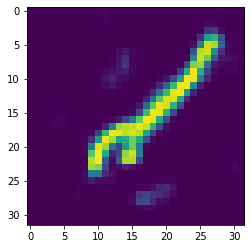

Discriminator out for this image: tensor([[0.0092]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1560
Discriminator loss: 0.07865081541240215
Generator loss: 13.956615447998047
Entering epoch no: 1561
Discriminator loss: 0.20957058668136597
Generator loss: 12.830467700958252
Entering epoch no: 1562
Discriminator loss: 0.1768639162182808
Generator loss: 12.707422733306885
Entering epoch no: 1563
Discriminator loss: 0.08880368992686272
Generator loss: 11.98265528678894
Entering epoch no: 1564
Discriminator loss: 0.0711737610399723
Generator loss: 11.679651498794556
Entering epoch no: 1565
Discriminator loss: 0.09166676551103592
Generator loss: 11.946199655532837
Entering epoch no: 1566
Discriminator loss: 0.12495174258947372
Generator loss: 12.894171237945557
Entering epoch no: 1567
Discriminator loss: 0.2502204477787018
Generator loss: 12.211167335510254
Entering epoch no: 1568
Discriminator loss: 0.15897785127162933
Generator loss: 12.804410696029663
Entering epoch n

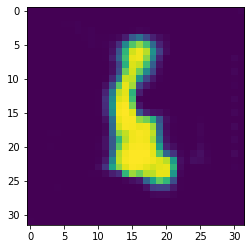

Discriminator out for this image: tensor([[0.0171]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1580
Discriminator loss: 0.14852424338459969
Generator loss: 11.949451208114624
Entering epoch no: 1581
Discriminator loss: 0.11652828752994537
Generator loss: 14.288783073425293
Entering epoch no: 1582
Discriminator loss: 0.24993979930877686
Generator loss: 15.468513011932373
Entering epoch no: 1583
Discriminator loss: 0.13021334260702133
Generator loss: 14.286477088928223
Entering epoch no: 1584
Discriminator loss: 0.2396392896771431
Generator loss: 12.862646102905273
Entering epoch no: 1585
Discriminator loss: 0.05259239673614502
Generator loss: 12.172126770019531
Entering epoch no: 1586
Discriminator loss: 0.11367175728082657
Generator loss: 12.835413932800293
Entering epoch no: 1587
Discriminator loss: 0.10393387638032436
Generator loss: 11.800360202789307
Entering epoch no: 1588
Discriminator loss: 0.07950851134955883
Generator loss: 12.551105499267578
Entering epoc

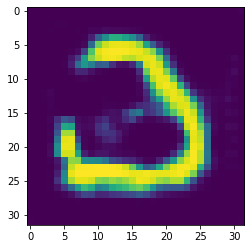

Discriminator out for this image: tensor([[0.0070]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1600
Discriminator loss: 0.08144663646817207
Generator loss: 11.583674907684326
Entering epoch no: 1601
Discriminator loss: 0.2225186750292778
Generator loss: 10.826569080352783
Entering epoch no: 1602
Discriminator loss: 0.13953913748264313
Generator loss: 12.097275018692017
Entering epoch no: 1603
Discriminator loss: 0.1282997839152813
Generator loss: 11.473747968673706
Entering epoch no: 1604
Discriminator loss: 0.07974251732230186
Generator loss: 11.722976684570312
Entering epoch no: 1605
Discriminator loss: 0.12384824827313423
Generator loss: 12.133502006530762
Entering epoch no: 1606
Discriminator loss: 0.11941735073924065
Generator loss: 11.331875801086426
Entering epoch no: 1607
Discriminator loss: 0.24322901666164398
Generator loss: 13.013416767120361
Entering epoch no: 1608
Discriminator loss: 0.19771163165569305
Generator loss: 12.498441696166992
Entering epoch

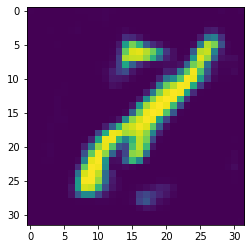

Discriminator out for this image: tensor([[0.0178]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1620
Discriminator loss: 0.11430944129824638
Generator loss: 10.328226566314697
Entering epoch no: 1621
Discriminator loss: 0.23783349990844727
Generator loss: 12.094955682754517
Entering epoch no: 1622
Discriminator loss: 0.24647165089845657
Generator loss: 11.853337049484253
Entering epoch no: 1623
Discriminator loss: 0.3055819422006607
Generator loss: 11.282544612884521
Entering epoch no: 1624
Discriminator loss: 0.18513518199324608
Generator loss: 10.025017738342285
Entering epoch no: 1625
Discriminator loss: 0.29180145263671875
Generator loss: 11.677915573120117
Entering epoch no: 1626
Discriminator loss: 0.14481078833341599
Generator loss: 10.569591283798218
Entering epoch no: 1627
Discriminator loss: 0.255340114235878
Generator loss: 12.765195369720459
Entering epoch no: 1628
Discriminator loss: 0.1471862569451332
Generator loss: 11.699804306030273
Entering epoch n

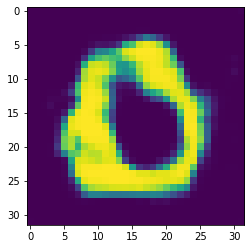

Discriminator out for this image: tensor([[0.0423]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1640
Discriminator loss: 0.2925393655896187
Generator loss: 6.741495132446289
Entering epoch no: 1641
Discriminator loss: 0.4895600825548172
Generator loss: 7.974359512329102
Entering epoch no: 1642
Discriminator loss: 0.46111784875392914
Generator loss: 9.611736536026001
Entering epoch no: 1643
Discriminator loss: 0.3330099731683731
Generator loss: 9.324459314346313
Entering epoch no: 1644
Discriminator loss: 0.3092474192380905
Generator loss: 9.381047010421753
Entering epoch no: 1645
Discriminator loss: 0.6013125479221344
Generator loss: 8.840319633483887
Entering epoch no: 1646
Discriminator loss: 0.6384401619434357
Generator loss: 9.69465160369873
Entering epoch no: 1647
Discriminator loss: 0.24887634068727493
Generator loss: 7.975201606750488
Entering epoch no: 1648
Discriminator loss: 0.4405706375837326
Generator loss: 8.2938072681427
Entering epoch no: 1649
Discrim

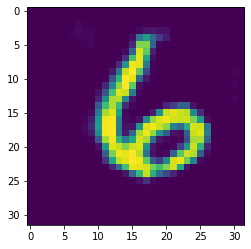

Discriminator out for this image: tensor([[0.0241]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1660
Discriminator loss: 0.17860425263643265
Generator loss: 10.537447929382324
Entering epoch no: 1661
Discriminator loss: 0.12544779479503632
Generator loss: 11.41331672668457
Entering epoch no: 1662
Discriminator loss: 0.18780270963907242
Generator loss: 11.848737478256226
Entering epoch no: 1663
Discriminator loss: 0.10927177593111992
Generator loss: 12.687337636947632
Entering epoch no: 1664
Discriminator loss: 0.35968564450740814
Generator loss: 13.129345417022705
Entering epoch no: 1665
Discriminator loss: 0.23784418404102325
Generator loss: 12.142522811889648
Entering epoch no: 1666
Discriminator loss: 0.3127339035272598
Generator loss: 9.367612838745117
Entering epoch no: 1667
Discriminator loss: 0.1764453575015068
Generator loss: 9.524436235427856
Entering epoch no: 1668
Discriminator loss: 0.31991127133369446
Generator loss: 8.643940687179565
Entering epoch no:

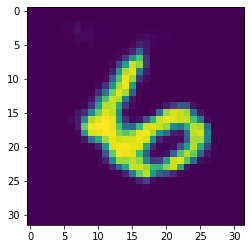

Discriminator out for this image: tensor([[0.1064]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1680
Discriminator loss: 0.14100851863622665
Generator loss: 10.892752408981323
Entering epoch no: 1681
Discriminator loss: 0.23233389109373093
Generator loss: 10.432133436203003
Entering epoch no: 1682
Discriminator loss: 0.4449310302734375
Generator loss: 12.009281396865845
Entering epoch no: 1683
Discriminator loss: 0.4479772597551346
Generator loss: 11.228184461593628
Entering epoch no: 1684
Discriminator loss: 0.29065462946891785
Generator loss: 11.104079008102417
Entering epoch no: 1685
Discriminator loss: 0.29873745143413544
Generator loss: 10.681129932403564
Entering epoch no: 1686
Discriminator loss: 0.26872967183589935
Generator loss: 9.7165687084198
Entering epoch no: 1687
Discriminator loss: 0.15839098393917084
Generator loss: 9.610960483551025
Entering epoch no: 1688
Discriminator loss: 0.19250782579183578
Generator loss: 9.943087577819824
Entering epoch no: 

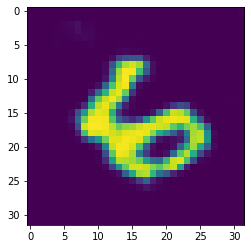

Discriminator out for this image: tensor([[0.0239]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1700
Discriminator loss: 0.22115150094032288
Generator loss: 12.643438339233398
Entering epoch no: 1701
Discriminator loss: 0.28904296457767487
Generator loss: 11.367144107818604
Entering epoch no: 1702
Discriminator loss: 0.19286715239286423
Generator loss: 13.250604152679443
Entering epoch no: 1703
Discriminator loss: 0.6551496088504791
Generator loss: 9.695922613143921
Entering epoch no: 1704
Discriminator loss: 0.17278247326612473
Generator loss: 6.744926691055298
Entering epoch no: 1705
Discriminator loss: 0.13195258751511574
Generator loss: 7.317894458770752
Entering epoch no: 1706
Discriminator loss: 0.42762017995119095
Generator loss: 8.558691024780273
Entering epoch no: 1707
Discriminator loss: 0.2252202033996582
Generator loss: 11.198599100112915
Entering epoch no: 1708
Discriminator loss: 0.3896566927433014
Generator loss: 12.25158977508545
Entering epoch no: 1

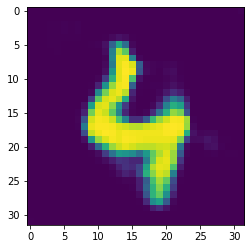

Discriminator out for this image: tensor([[0.0158]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1720
Discriminator loss: 0.346679225564003
Generator loss: 8.88154411315918
Entering epoch no: 1721
Discriminator loss: 0.3302803188562393
Generator loss: 7.774612188339233
Entering epoch no: 1722
Discriminator loss: 0.17559605464339256
Generator loss: 8.974217414855957
Entering epoch no: 1723
Discriminator loss: 0.24972012639045715
Generator loss: 10.463633060455322
Entering epoch no: 1724
Discriminator loss: 0.1612556166946888
Generator loss: 12.22289514541626
Entering epoch no: 1725
Discriminator loss: 0.2516109496355057
Generator loss: 14.03305196762085
Entering epoch no: 1726
Discriminator loss: 0.5585388243198395
Generator loss: 12.026541233062744
Entering epoch no: 1727
Discriminator loss: 0.4135904759168625
Generator loss: 9.844440698623657
Entering epoch no: 1728
Discriminator loss: 0.19653809070587158
Generator loss: 7.454345226287842
Entering epoch no: 1729
Dis

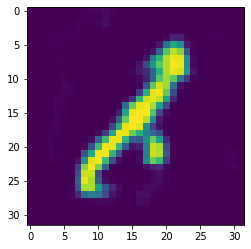

Discriminator out for this image: tensor([[0.0440]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1740
Discriminator loss: 0.19537411630153656
Generator loss: 10.110960006713867
Entering epoch no: 1741
Discriminator loss: 0.10479936189949512
Generator loss: 11.500206232070923
Entering epoch no: 1742
Discriminator loss: 0.17859943211078644
Generator loss: 11.898720502853394
Entering epoch no: 1743
Discriminator loss: 0.1794675812125206
Generator loss: 12.600053787231445
Entering epoch no: 1744
Discriminator loss: 0.4235922545194626
Generator loss: 10.932521343231201
Entering epoch no: 1745
Discriminator loss: 0.48168647289276123
Generator loss: 11.297127723693848
Entering epoch no: 1746
Discriminator loss: 0.11478080041706562
Generator loss: 7.993531942367554
Entering epoch no: 1747
Discriminator loss: 0.24082906916737556
Generator loss: 7.6806480884552
Entering epoch no: 1748
Discriminator loss: 0.1946137323975563
Generator loss: 10.753364324569702
Entering epoch no: 

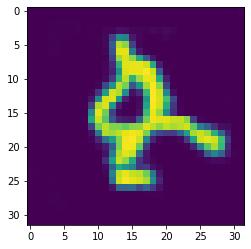

Discriminator out for this image: tensor([[0.0256]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1760
Discriminator loss: 0.3282529413700104
Generator loss: 11.15895962715149
Entering epoch no: 1761
Discriminator loss: 0.30009371042251587
Generator loss: 10.388216972351074
Entering epoch no: 1762
Discriminator loss: 0.25337061285972595
Generator loss: 10.29440426826477
Entering epoch no: 1763
Discriminator loss: 0.25819380581378937
Generator loss: 9.170579671859741
Entering epoch no: 1764
Discriminator loss: 0.19666677340865135
Generator loss: 8.967240810394287
Entering epoch no: 1765
Discriminator loss: 0.15847475081682205
Generator loss: 9.59708571434021
Entering epoch no: 1766
Discriminator loss: 0.3068663030862808
Generator loss: 11.054009199142456
Entering epoch no: 1767
Discriminator loss: 0.40011049807071686
Generator loss: 13.339210987091064
Entering epoch no: 1768
Discriminator loss: 0.22876568138599396
Generator loss: 12.802585124969482
Entering epoch no: 1

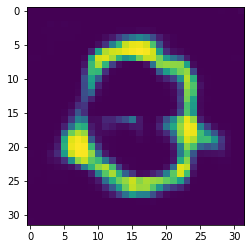

Discriminator out for this image: tensor([[0.1132]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1780
Discriminator loss: 0.254019096493721
Generator loss: 8.423508644104004
Entering epoch no: 1781
Discriminator loss: 0.3105873540043831
Generator loss: 8.288798809051514
Entering epoch no: 1782
Discriminator loss: 0.25510771572589874
Generator loss: 7.592497825622559
Entering epoch no: 1783
Discriminator loss: 0.25530948489904404
Generator loss: 8.535351991653442
Entering epoch no: 1784
Discriminator loss: 0.15306644514203072
Generator loss: 11.32223892211914
Entering epoch no: 1785
Discriminator loss: 0.1903153881430626
Generator loss: 10.789622783660889
Entering epoch no: 1786
Discriminator loss: 0.2713216096162796
Generator loss: 12.25779104232788
Entering epoch no: 1787
Discriminator loss: 0.12509028613567352
Generator loss: 11.343465805053711
Entering epoch no: 1788
Discriminator loss: 0.17236827313899994
Generator loss: 10.40871286392212
Entering epoch no: 1789


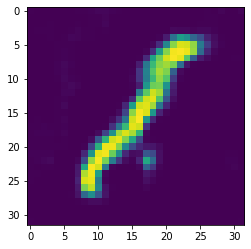

Discriminator out for this image: tensor([[0.0536]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1800
Discriminator loss: 0.29489365220069885
Generator loss: 11.16976284980774
Entering epoch no: 1801
Discriminator loss: 0.1834605261683464
Generator loss: 10.139823198318481
Entering epoch no: 1802
Discriminator loss: 0.23297680914402008
Generator loss: 8.53147554397583
Entering epoch no: 1803
Discriminator loss: 0.2608582004904747
Generator loss: 8.853297233581543
Entering epoch no: 1804
Discriminator loss: 0.28933829069137573
Generator loss: 10.060394048690796
Entering epoch no: 1805
Discriminator loss: 0.21588823199272156
Generator loss: 12.368764400482178
Entering epoch no: 1806
Discriminator loss: 0.26894813776016235
Generator loss: 11.807068586349487
Entering epoch no: 1807
Discriminator loss: 0.22556978464126587
Generator loss: 11.285745859146118
Entering epoch no: 1808
Discriminator loss: 0.22627079486846924
Generator loss: 9.404406309127808
Entering epoch no: 

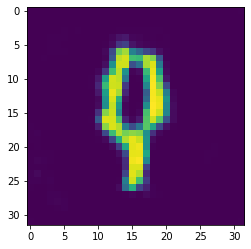

Discriminator out for this image: tensor([[0.0922]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1820
Discriminator loss: 0.4209257960319519
Generator loss: 8.245561242103577
Entering epoch no: 1821
Discriminator loss: 0.4928757846355438
Generator loss: 9.452592611312866
Entering epoch no: 1822
Discriminator loss: 0.5602217614650726
Generator loss: 10.930511951446533
Entering epoch no: 1823
Discriminator loss: 0.5495641678571701
Generator loss: 8.066853284835815
Entering epoch no: 1824
Discriminator loss: 0.5164846777915955
Generator loss: 8.562181949615479
Entering epoch no: 1825
Discriminator loss: 0.5286864340305328
Generator loss: 8.353209257125854
Entering epoch no: 1826
Discriminator loss: 0.4119015783071518
Generator loss: 10.974405288696289
Entering epoch no: 1827
Discriminator loss: 0.30447347462177277
Generator loss: 11.429909944534302
Entering epoch no: 1828
Discriminator loss: 0.5515347719192505
Generator loss: 10.265849113464355
Entering epoch no: 1829
D

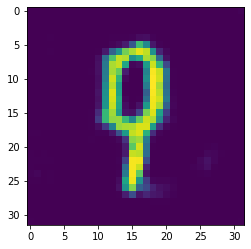

Discriminator out for this image: tensor([[0.0959]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1840
Discriminator loss: 0.2237354815006256
Generator loss: 11.328810453414917
Entering epoch no: 1841
Discriminator loss: 0.3083372563123703
Generator loss: 11.64537501335144
Entering epoch no: 1842
Discriminator loss: 0.3366503417491913
Generator loss: 12.942736148834229
Entering epoch no: 1843
Discriminator loss: 0.6353311836719513
Generator loss: 10.804356098175049
Entering epoch no: 1844
Discriminator loss: 0.3747638911008835
Generator loss: 9.727231979370117
Entering epoch no: 1845
Discriminator loss: 0.29320085048675537
Generator loss: 8.255594253540039
Entering epoch no: 1846
Discriminator loss: 0.5350388884544373
Generator loss: 7.094548225402832
Entering epoch no: 1847
Discriminator loss: 0.28896966576576233
Generator loss: 9.483901739120483
Entering epoch no: 1848
Discriminator loss: 0.403484508395195
Generator loss: 11.0013267993927
Entering epoch no: 1849
Dis

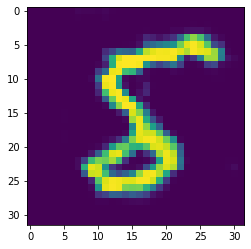

Discriminator out for this image: tensor([[0.0099]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1860
Discriminator loss: 0.3372924029827118
Generator loss: 8.68288540840149
Entering epoch no: 1861
Discriminator loss: 0.30647125095129013
Generator loss: 9.039533615112305
Entering epoch no: 1862
Discriminator loss: 0.4129709303379059
Generator loss: 9.756900787353516
Entering epoch no: 1863
Discriminator loss: 0.34799911081790924
Generator loss: 11.12890076637268
Entering epoch no: 1864
Discriminator loss: 0.5587192922830582
Generator loss: 12.789568424224854
Entering epoch no: 1865
Discriminator loss: 0.34412699937820435
Generator loss: 10.229057312011719
Entering epoch no: 1866
Discriminator loss: 0.3276248127222061
Generator loss: 9.609696626663208
Entering epoch no: 1867
Discriminator loss: 0.35534997284412384
Generator loss: 7.856381416320801
Entering epoch no: 1868
Discriminator loss: 0.5734275579452515
Generator loss: 9.846307039260864
Entering epoch no: 1869
D

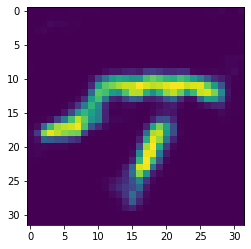

Discriminator out for this image: tensor([[0.1479]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1880
Discriminator loss: 0.6222589910030365
Generator loss: 11.494677782058716
Entering epoch no: 1881
Discriminator loss: 0.21656708419322968
Generator loss: 8.670776128768921
Entering epoch no: 1882
Discriminator loss: 0.4035130888223648
Generator loss: 9.759354829788208
Entering epoch no: 1883
Discriminator loss: 0.20602460950613022
Generator loss: 10.050947427749634
Entering epoch no: 1884
Discriminator loss: 0.29886066913604736
Generator loss: 7.321800708770752
Entering epoch no: 1885
Discriminator loss: 0.2577345371246338
Generator loss: 9.672972440719604
Entering epoch no: 1886
Discriminator loss: 0.19442898035049438
Generator loss: 11.138150691986084
Entering epoch no: 1887
Discriminator loss: 0.17294074594974518
Generator loss: 11.622939586639404
Entering epoch no: 1888
Discriminator loss: 0.48206178843975067
Generator loss: 12.512889385223389
Entering epoch no: 

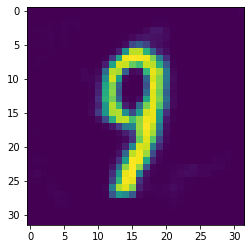

Discriminator out for this image: tensor([[0.0838]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1900
Discriminator loss: 0.41243577003479004
Generator loss: 6.983116626739502
Entering epoch no: 1901
Discriminator loss: 0.3946801573038101
Generator loss: 5.961221933364868
Entering epoch no: 1902
Discriminator loss: 0.3486279435455799
Generator loss: 8.13956332206726
Entering epoch no: 1903
Discriminator loss: 0.2612045109272003
Generator loss: 11.292906284332275
Entering epoch no: 1904
Discriminator loss: 0.37998145818710327
Generator loss: 12.106501579284668
Entering epoch no: 1905
Discriminator loss: 0.6433194279670715
Generator loss: 12.700720310211182
Entering epoch no: 1906
Discriminator loss: 0.421681672334671
Generator loss: 8.651455402374268
Entering epoch no: 1907
Discriminator loss: 0.2716974914073944
Generator loss: 9.430854558944702
Entering epoch no: 1908
Discriminator loss: 0.4038633853197098
Generator loss: 9.431015729904175
Entering epoch no: 1909
Dis

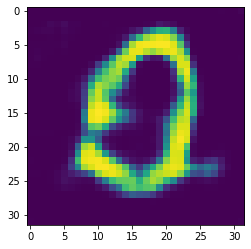

Discriminator out for this image: tensor([[0.1659]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1920
Discriminator loss: 0.5642917901277542
Generator loss: 8.947453022003174
Entering epoch no: 1921
Discriminator loss: 0.5327452719211578
Generator loss: 10.144447803497314
Entering epoch no: 1922
Discriminator loss: 0.5149055570363998
Generator loss: 9.081658840179443
Entering epoch no: 1923
Discriminator loss: 0.3677595555782318
Generator loss: 8.416389226913452
Entering epoch no: 1924
Discriminator loss: 0.23583200573921204
Generator loss: 7.624651670455933
Entering epoch no: 1925
Discriminator loss: 0.39263486862182617
Generator loss: 7.512348175048828
Entering epoch no: 1926
Discriminator loss: 0.4646201580762863
Generator loss: 10.239566564559937
Entering epoch no: 1927
Discriminator loss: 0.5042269080877304
Generator loss: 8.36372709274292
Entering epoch no: 1928
Discriminator loss: 0.6067251861095428
Generator loss: 9.110278606414795
Entering epoch no: 1929
Dis

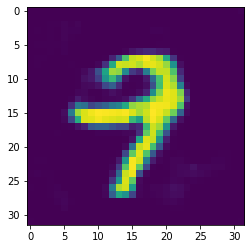

Discriminator out for this image: tensor([[0.1023]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1940
Discriminator loss: 0.20901597663760185
Generator loss: 8.648681402206421
Entering epoch no: 1941
Discriminator loss: 0.43559107184410095
Generator loss: 10.470242738723755
Entering epoch no: 1942
Discriminator loss: 0.5090504288673401
Generator loss: 10.068955183029175
Entering epoch no: 1943
Discriminator loss: 0.42790812253952026
Generator loss: 9.834570169448853
Entering epoch no: 1944
Discriminator loss: 0.2903587147593498
Generator loss: 9.678728818893433
Entering epoch no: 1945
Discriminator loss: 0.4281817227602005
Generator loss: 9.447118759155273
Entering epoch no: 1946
Discriminator loss: 0.34282903373241425
Generator loss: 9.425905704498291
Entering epoch no: 1947
Discriminator loss: 0.17174656689167023
Generator loss: 9.107819557189941
Entering epoch no: 1948
Discriminator loss: 0.25014154613018036
Generator loss: 11.60275411605835
Entering epoch no: 194

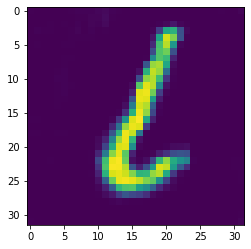

Discriminator out for this image: tensor([[0.0089]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1960
Discriminator loss: 0.21707166731357574
Generator loss: 10.732845783233643
Entering epoch no: 1961
Discriminator loss: 0.36320680379867554
Generator loss: 11.530686855316162
Entering epoch no: 1962
Discriminator loss: 0.16993440687656403
Generator loss: 11.404053926467896
Entering epoch no: 1963
Discriminator loss: 0.26454533636569977
Generator loss: 11.039304971694946
Entering epoch no: 1964
Discriminator loss: 0.3519691824913025
Generator loss: 10.287588834762573
Entering epoch no: 1965
Discriminator loss: 0.283633217215538
Generator loss: 10.219724178314209
Entering epoch no: 1966
Discriminator loss: 0.34202809631824493
Generator loss: 9.622239828109741
Entering epoch no: 1967
Discriminator loss: 0.4840896427631378
Generator loss: 7.704054594039917
Entering epoch no: 1968
Discriminator loss: 0.27323876321315765
Generator loss: 8.42528748512268
Entering epoch no: 1

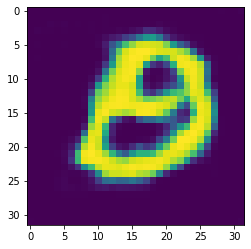

Discriminator out for this image: tensor([[0.0293]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 1980
Discriminator loss: 0.6752449572086334
Generator loss: 12.613996982574463
Entering epoch no: 1981
Discriminator loss: 0.406143382191658
Generator loss: 9.824328899383545
Entering epoch no: 1982
Discriminator loss: 0.4603393077850342
Generator loss: 8.517707586288452
Entering epoch no: 1983
Discriminator loss: 0.3966358155012131
Generator loss: 8.740831851959229
Entering epoch no: 1984
Discriminator loss: 0.5035528540611267
Generator loss: 8.05554485321045
Entering epoch no: 1985
Discriminator loss: 0.19887461513280869
Generator loss: 7.748902082443237
Entering epoch no: 1986
Discriminator loss: 0.4022854045033455
Generator loss: 8.025908946990967
Entering epoch no: 1987
Discriminator loss: 0.331037312746048
Generator loss: 11.111246824264526
Entering epoch no: 1988
Discriminator loss: 0.4692513942718506
Generator loss: 12.4339017868042
Entering epoch no: 1989
Discrim

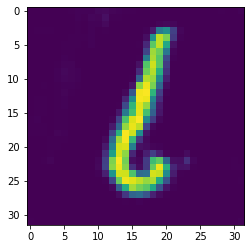

Discriminator out for this image: tensor([[0.0155]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2000
Discriminator loss: 0.3565983474254608
Generator loss: 9.084770917892456
Entering epoch no: 2001
Discriminator loss: 0.36965087801218033
Generator loss: 9.968063592910767
Entering epoch no: 2002
Discriminator loss: 0.34604931622743607
Generator loss: 9.769318103790283
Entering epoch no: 2003
Discriminator loss: 0.14026078395545483
Generator loss: 12.329795122146606
Entering epoch no: 2004
Discriminator loss: 0.48115842044353485
Generator loss: 12.41860294342041
Entering epoch no: 2005
Discriminator loss: 0.3372475802898407
Generator loss: 12.004317283630371
Entering epoch no: 2006
Discriminator loss: 0.29114122688770294
Generator loss: 11.53579068183899
Entering epoch no: 2007
Discriminator loss: 0.369938388466835
Generator loss: 10.0707688331604
Entering epoch no: 2008
Discriminator loss: 0.571249932050705
Generator loss: 9.235284090042114
Entering epoch no: 2009
Di

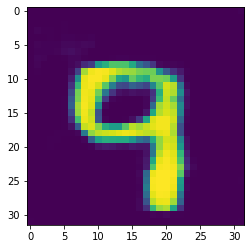

Discriminator out for this image: tensor([[0.1100]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2020
Discriminator loss: 0.45255139470100403
Generator loss: 8.15177583694458
Entering epoch no: 2021
Discriminator loss: 0.2923976927995682
Generator loss: 7.195023775100708
Entering epoch no: 2022
Discriminator loss: 0.3225218653678894
Generator loss: 9.126488447189331
Entering epoch no: 2023
Discriminator loss: 0.32617055624723434
Generator loss: 7.884145498275757
Entering epoch no: 2024
Discriminator loss: 0.4768797606229782
Generator loss: 10.743728637695312
Entering epoch no: 2025
Discriminator loss: 0.5665291845798492
Generator loss: 10.733799457550049
Entering epoch no: 2026
Discriminator loss: 0.17100461572408676
Generator loss: 10.456591367721558
Entering epoch no: 2027
Discriminator loss: 0.21933165937662125
Generator loss: 10.90239691734314
Entering epoch no: 2028
Discriminator loss: 0.15516352280974388
Generator loss: 9.614514589309692
Entering epoch no: 2029

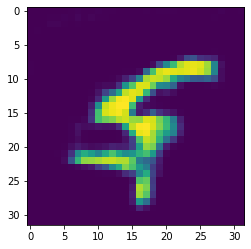

Discriminator out for this image: tensor([[0.0560]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2040
Discriminator loss: 0.35107482969760895
Generator loss: 10.384815454483032
Entering epoch no: 2041
Discriminator loss: 0.3284791633486748
Generator loss: 10.626262426376343
Entering epoch no: 2042
Discriminator loss: 0.3722088634967804
Generator loss: 11.627944946289062
Entering epoch no: 2043
Discriminator loss: 0.4374370723962784
Generator loss: 11.643584489822388
Entering epoch no: 2044
Discriminator loss: 0.2644116207957268
Generator loss: 11.670199394226074
Entering epoch no: 2045
Discriminator loss: 0.23085881769657135
Generator loss: 10.643997430801392
Entering epoch no: 2046
Discriminator loss: 0.3560156971216202
Generator loss: 8.911271810531616
Entering epoch no: 2047
Discriminator loss: 0.3001277297735214
Generator loss: 7.528851270675659
Entering epoch no: 2048
Discriminator loss: 0.4216848760843277
Generator loss: 8.879139423370361
Entering epoch no: 204

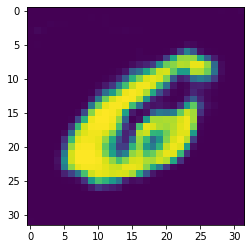

Discriminator out for this image: tensor([[0.1083]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2060
Discriminator loss: 0.2792707458138466
Generator loss: 8.544270515441895
Entering epoch no: 2061
Discriminator loss: 0.32115158438682556
Generator loss: 9.0872061252594
Entering epoch no: 2062
Discriminator loss: 0.16402581334114075
Generator loss: 9.710467100143433
Entering epoch no: 2063
Discriminator loss: 0.23303338885307312
Generator loss: 11.190089464187622
Entering epoch no: 2064
Discriminator loss: 0.5171495079994202
Generator loss: 11.633733987808228
Entering epoch no: 2065
Discriminator loss: 0.3793390691280365
Generator loss: 11.838825225830078
Entering epoch no: 2066
Discriminator loss: 0.3595494329929352
Generator loss: 9.632220029830933
Entering epoch no: 2067
Discriminator loss: 0.25378990173339844
Generator loss: 9.013157367706299
Entering epoch no: 2068
Discriminator loss: 0.3021576702594757
Generator loss: 10.257818698883057
Entering epoch no: 2069


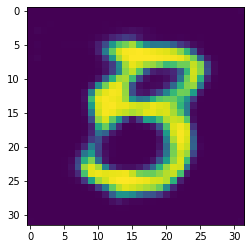

Discriminator out for this image: tensor([[0.2202]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2080
Discriminator loss: 0.3153965249657631
Generator loss: 10.306093454360962
Entering epoch no: 2081
Discriminator loss: 0.223733052611351
Generator loss: 12.041651248931885
Entering epoch no: 2082
Discriminator loss: 0.30230429768562317
Generator loss: 13.62417221069336
Entering epoch no: 2083
Discriminator loss: 0.337041437625885
Generator loss: 13.016421794891357
Entering epoch no: 2084
Discriminator loss: 0.29164984822273254
Generator loss: 11.452284097671509
Entering epoch no: 2085
Discriminator loss: 0.28255918622016907
Generator loss: 10.560412406921387
Entering epoch no: 2086
Discriminator loss: 0.2618248537182808
Generator loss: 8.737624883651733
Entering epoch no: 2087
Discriminator loss: 0.11470739543437958
Generator loss: 7.604050874710083
Entering epoch no: 2088
Discriminator loss: 0.2105860933661461
Generator loss: 8.695098876953125
Entering epoch no: 2089

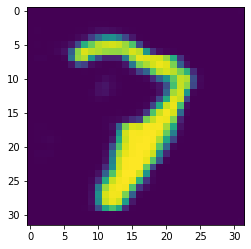

Discriminator out for this image: tensor([[0.0304]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2100
Discriminator loss: 0.34294936060905457
Generator loss: 7.748471260070801
Entering epoch no: 2101
Discriminator loss: 0.3077028691768646
Generator loss: 9.803702592849731
Entering epoch no: 2102
Discriminator loss: 0.5006140172481537
Generator loss: 8.908726930618286
Entering epoch no: 2103
Discriminator loss: 0.3364115357398987
Generator loss: 8.186258554458618
Entering epoch no: 2104
Discriminator loss: 0.32701241970062256
Generator loss: 8.925150871276855
Entering epoch no: 2105
Discriminator loss: 0.3348366767168045
Generator loss: 8.836214303970337
Entering epoch no: 2106
Discriminator loss: 0.3232855200767517
Generator loss: 8.082797050476074
Entering epoch no: 2107
Discriminator loss: 0.39644964039325714
Generator loss: 8.301955461502075
Entering epoch no: 2108
Discriminator loss: 0.37724047899246216
Generator loss: 8.062798976898193
Entering epoch no: 2109
Di

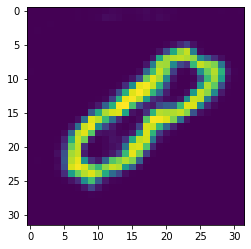

Discriminator out for this image: tensor([[0.0325]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2120
Discriminator loss: 0.3974929600954056
Generator loss: 9.276770114898682
Entering epoch no: 2121
Discriminator loss: 0.3178328424692154
Generator loss: 10.470208168029785
Entering epoch no: 2122
Discriminator loss: 0.33710287511348724
Generator loss: 6.945253133773804
Entering epoch no: 2123
Discriminator loss: 0.37742581963539124
Generator loss: 6.455721139907837
Entering epoch no: 2124
Discriminator loss: 0.34946900606155396
Generator loss: 6.571571230888367
Entering epoch no: 2125
Discriminator loss: 0.40627552568912506
Generator loss: 11.19918179512024
Entering epoch no: 2126
Discriminator loss: 0.21616113930940628
Generator loss: 11.899232864379883
Entering epoch no: 2127
Discriminator loss: 0.8104616403579712
Generator loss: 13.259780883789062
Entering epoch no: 2128
Discriminator loss: 1.1922740936279297
Generator loss: 8.90805959701538
Entering epoch no: 2129

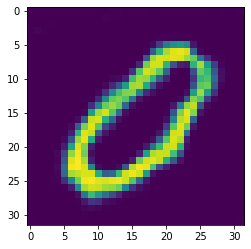

Discriminator out for this image: tensor([[0.1290]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2140
Discriminator loss: 0.45697160065174103
Generator loss: 9.479272842407227
Entering epoch no: 2141
Discriminator loss: 0.39818961918354034
Generator loss: 9.208951473236084
Entering epoch no: 2142
Discriminator loss: 0.5180725157260895
Generator loss: 9.227470874786377
Entering epoch no: 2143
Discriminator loss: 0.42678631097078323
Generator loss: 9.908990621566772
Entering epoch no: 2144
Discriminator loss: 0.20657089352607727
Generator loss: 11.237891912460327
Entering epoch no: 2145
Discriminator loss: 0.6355356276035309
Generator loss: 10.914332151412964
Entering epoch no: 2146
Discriminator loss: 0.6336855292320251
Generator loss: 9.909222841262817
Entering epoch no: 2147
Discriminator loss: 0.21466217935085297
Generator loss: 8.6893470287323
Entering epoch no: 2148
Discriminator loss: 0.30205968022346497
Generator loss: 8.847564458847046
Entering epoch no: 2149


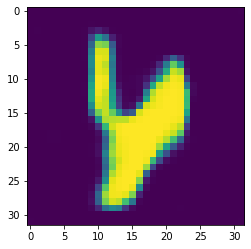

Discriminator out for this image: tensor([[0.1062]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2160
Discriminator loss: 0.39424531161785126
Generator loss: 8.831469058990479
Entering epoch no: 2161
Discriminator loss: 0.3272469490766525
Generator loss: 10.354985237121582
Entering epoch no: 2162
Discriminator loss: 0.3098877966403961
Generator loss: 13.045268535614014
Entering epoch no: 2163
Discriminator loss: 0.2676575407385826
Generator loss: 12.563137531280518
Entering epoch no: 2164
Discriminator loss: 0.2626943960785866
Generator loss: 12.270509719848633
Entering epoch no: 2165
Discriminator loss: 0.6611047685146332
Generator loss: 11.341775178909302
Entering epoch no: 2166
Discriminator loss: 0.2033315747976303
Generator loss: 9.013728380203247
Entering epoch no: 2167
Discriminator loss: 0.2969755083322525
Generator loss: 8.377619981765747
Entering epoch no: 2168
Discriminator loss: 0.35163895785808563
Generator loss: 8.440619230270386
Entering epoch no: 2169

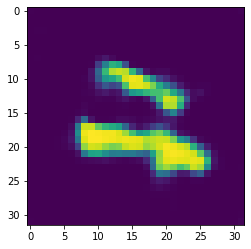

Discriminator out for this image: tensor([[0.0100]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2180
Discriminator loss: 0.47870489954948425
Generator loss: 10.139180421829224
Entering epoch no: 2181
Discriminator loss: 0.4150671884417534
Generator loss: 8.889670133590698
Entering epoch no: 2182
Discriminator loss: 0.29861922562122345
Generator loss: 8.043638706207275
Entering epoch no: 2183
Discriminator loss: 0.18479586020112038
Generator loss: 9.54733395576477
Entering epoch no: 2184
Discriminator loss: 0.20599522069096565
Generator loss: 12.905006408691406
Entering epoch no: 2185
Discriminator loss: 0.19712136685848236
Generator loss: 12.671765565872192
Entering epoch no: 2186
Discriminator loss: 0.18084365874528885
Generator loss: 14.40992021560669
Entering epoch no: 2187
Discriminator loss: 0.21497754007577896
Generator loss: 14.215740203857422
Entering epoch no: 2188
Discriminator loss: 0.2765718176960945
Generator loss: 14.48771858215332
Entering epoch no: 2

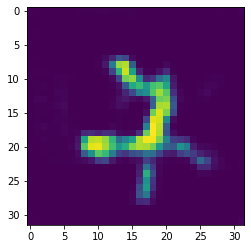

Discriminator out for this image: tensor([[0.0622]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2200
Discriminator loss: 0.2721872851252556
Generator loss: 10.493740320205688
Entering epoch no: 2201
Discriminator loss: 0.30621057748794556
Generator loss: 10.01646113395691
Entering epoch no: 2202
Discriminator loss: 0.13067704811692238
Generator loss: 9.556471109390259
Entering epoch no: 2203
Discriminator loss: 0.4732973873615265
Generator loss: 10.091151714324951
Entering epoch no: 2204
Discriminator loss: 0.3392274007201195
Generator loss: 9.455892086029053
Entering epoch no: 2205
Discriminator loss: 0.22314509749412537
Generator loss: 9.644588947296143
Entering epoch no: 2206
Discriminator loss: 0.5235816538333893
Generator loss: 11.485644340515137
Entering epoch no: 2207
Discriminator loss: 0.2375021129846573
Generator loss: 10.58551573753357
Entering epoch no: 2208
Discriminator loss: 0.2999812811613083
Generator loss: 10.338726043701172
Entering epoch no: 2209

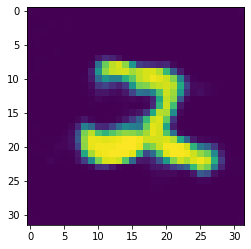

Discriminator out for this image: tensor([[0.0058]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2220
Discriminator loss: 0.7065808176994324
Generator loss: 9.085023164749146
Entering epoch no: 2221
Discriminator loss: 0.2523755617439747
Generator loss: 7.524798631668091
Entering epoch no: 2222
Discriminator loss: 0.3934270218014717
Generator loss: 7.4173760414123535
Entering epoch no: 2223
Discriminator loss: 0.45228826999664307
Generator loss: 11.827579736709595
Entering epoch no: 2224
Discriminator loss: 0.6904759407043457
Generator loss: 13.078058004379272
Entering epoch no: 2225
Discriminator loss: 0.601456493139267
Generator loss: 13.016717433929443
Entering epoch no: 2226
Discriminator loss: 0.3753161281347275
Generator loss: 11.306263446807861
Entering epoch no: 2227
Discriminator loss: 0.23710891604423523
Generator loss: 8.369338512420654
Entering epoch no: 2228
Discriminator loss: 0.32850418984889984
Generator loss: 9.546022891998291
Entering epoch no: 2229

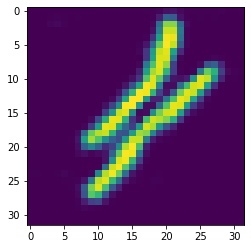

Discriminator out for this image: tensor([[0.0243]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2240
Discriminator loss: 0.1330660656094551
Generator loss: 10.417613506317139
Entering epoch no: 2241
Discriminator loss: 0.18651089817285538
Generator loss: 9.510460376739502
Entering epoch no: 2242
Discriminator loss: 0.19629065319895744
Generator loss: 11.117324113845825
Entering epoch no: 2243
Discriminator loss: 0.12206298112869263
Generator loss: 10.384997606277466
Entering epoch no: 2244
Discriminator loss: 0.2685166448354721
Generator loss: 11.92287302017212
Entering epoch no: 2245
Discriminator loss: 0.11104634590446949
Generator loss: 14.221392631530762
Entering epoch no: 2246
Discriminator loss: 0.26780012249946594
Generator loss: 13.813240051269531
Entering epoch no: 2247
Discriminator loss: 0.22953446954488754
Generator loss: 14.11947774887085
Entering epoch no: 2248
Discriminator loss: 0.15179378166794777
Generator loss: 13.791425228118896
Entering epoch no

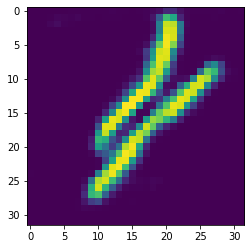

Discriminator out for this image: tensor([[0.0129]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2260
Discriminator loss: 0.3095054253935814
Generator loss: 9.86533808708191
Entering epoch no: 2261
Discriminator loss: 0.2023853361606598
Generator loss: 10.440223932266235
Entering epoch no: 2262
Discriminator loss: 0.4878840446472168
Generator loss: 11.497653722763062
Entering epoch no: 2263
Discriminator loss: 0.3136681690812111
Generator loss: 9.360868215560913
Entering epoch no: 2264
Discriminator loss: 0.2551158741116524
Generator loss: 9.541185855865479
Entering epoch no: 2265
Discriminator loss: 0.19256867468357086
Generator loss: 11.649903059005737
Entering epoch no: 2266
Discriminator loss: 0.46302124857902527
Generator loss: 11.09182333946228
Entering epoch no: 2267
Discriminator loss: 0.40973611176013947
Generator loss: 9.044699668884277
Entering epoch no: 2268
Discriminator loss: 0.24337200075387955
Generator loss: 8.050671815872192
Entering epoch no: 2269


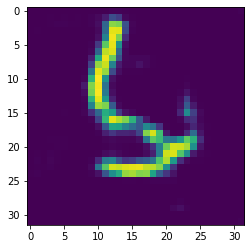

Discriminator out for this image: tensor([[0.1476]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2280
Discriminator loss: 0.1168246865272522
Generator loss: 12.25562858581543
Entering epoch no: 2281
Discriminator loss: 0.13117437064647675
Generator loss: 14.4794921875
Entering epoch no: 2282
Discriminator loss: 0.35758809745311737
Generator loss: 15.575880527496338
Entering epoch no: 2283
Discriminator loss: 0.21956684440374374
Generator loss: 13.326059341430664
Entering epoch no: 2284
Discriminator loss: 0.3311978876590729
Generator loss: 13.601276397705078
Entering epoch no: 2285
Discriminator loss: 0.3585876226425171
Generator loss: 10.455422401428223
Entering epoch no: 2286
Discriminator loss: 0.26353148370981216
Generator loss: 9.718631744384766
Entering epoch no: 2287
Discriminator loss: 0.31661516427993774
Generator loss: 6.612486362457275
Entering epoch no: 2288
Discriminator loss: 0.2932080775499344
Generator loss: 7.098051309585571
Entering epoch no: 2289
D

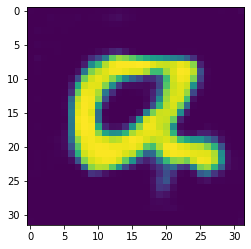

Discriminator out for this image: tensor([[0.0281]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2300
Discriminator loss: 0.09956572577357292
Generator loss: 12.433927297592163
Entering epoch no: 2301
Discriminator loss: 0.20125647634267807
Generator loss: 15.326471328735352
Entering epoch no: 2302
Discriminator loss: 0.2399987429380417
Generator loss: 14.8324556350708
Entering epoch no: 2303
Discriminator loss: 0.1891094148159027
Generator loss: 13.899099349975586
Entering epoch no: 2304
Discriminator loss: 0.3356591910123825
Generator loss: 12.188570976257324
Entering epoch no: 2305
Discriminator loss: 0.2568507269024849
Generator loss: 9.708216428756714
Entering epoch no: 2306
Discriminator loss: 0.17140138149261475
Generator loss: 8.848202228546143
Entering epoch no: 2307
Discriminator loss: 0.41230760514736176
Generator loss: 8.296899557113647
Entering epoch no: 2308
Discriminator loss: 0.40716350078582764
Generator loss: 8.10765552520752
Entering epoch no: 2309

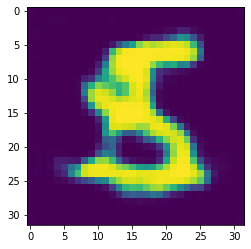

Discriminator out for this image: tensor([[0.0197]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2320
Discriminator loss: 0.4897472411394119
Generator loss: 11.140537977218628
Entering epoch no: 2321
Discriminator loss: 0.21919739991426468
Generator loss: 8.812931060791016
Entering epoch no: 2322
Discriminator loss: 0.1479836218059063
Generator loss: 8.269442319869995
Entering epoch no: 2323
Discriminator loss: 0.24351444095373154
Generator loss: 7.7270002365112305
Entering epoch no: 2324
Discriminator loss: 0.15004916861653328
Generator loss: 9.324050903320312
Entering epoch no: 2325
Discriminator loss: 0.2329561561346054
Generator loss: 11.096985578536987
Entering epoch no: 2326
Discriminator loss: 0.14843937009572983
Generator loss: 9.732228994369507
Entering epoch no: 2327
Discriminator loss: 0.3020116537809372
Generator loss: 11.049698114395142
Entering epoch no: 2328
Discriminator loss: 0.2953450530767441
Generator loss: 10.530970573425293
Entering epoch no: 23

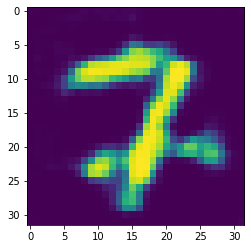

Discriminator out for this image: tensor([[0.0410]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2340
Discriminator loss: 0.2161594033241272
Generator loss: 10.262653827667236
Entering epoch no: 2341
Discriminator loss: 0.16661128401756287
Generator loss: 9.435141324996948
Entering epoch no: 2342
Discriminator loss: 0.22789305448532104
Generator loss: 9.975477933883667
Entering epoch no: 2343
Discriminator loss: 0.201578501611948
Generator loss: 11.121434688568115
Entering epoch no: 2344
Discriminator loss: 0.18403145670890808
Generator loss: 12.275107622146606
Entering epoch no: 2345
Discriminator loss: 0.32023337483406067
Generator loss: 10.938581705093384
Entering epoch no: 2346
Discriminator loss: 0.2369680441915989
Generator loss: 10.861340761184692
Entering epoch no: 2347
Discriminator loss: 0.36782313883304596
Generator loss: 10.943289756774902
Entering epoch no: 2348
Discriminator loss: 0.4963223338127136
Generator loss: 11.621082067489624
Entering epoch no: 

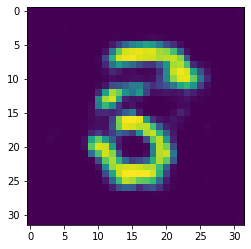

Discriminator out for this image: tensor([[0.3488]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2360
Discriminator loss: 0.22317039221525192
Generator loss: 9.366315841674805
Entering epoch no: 2361
Discriminator loss: 0.38928942382335663
Generator loss: 7.910020589828491
Entering epoch no: 2362
Discriminator loss: 0.46595244109630585
Generator loss: 9.154483079910278
Entering epoch no: 2363
Discriminator loss: 0.5410523265600204
Generator loss: 10.671822547912598
Entering epoch no: 2364
Discriminator loss: 0.29773643612861633
Generator loss: 11.503699541091919
Entering epoch no: 2365
Discriminator loss: 0.4728073477745056
Generator loss: 10.767043113708496
Entering epoch no: 2366
Discriminator loss: 0.5378628224134445
Generator loss: 10.552620887756348
Entering epoch no: 2367
Discriminator loss: 0.1817488595843315
Generator loss: 9.946763515472412
Entering epoch no: 2368
Discriminator loss: 0.21929050981998444
Generator loss: 10.460472345352173
Entering epoch no: 2

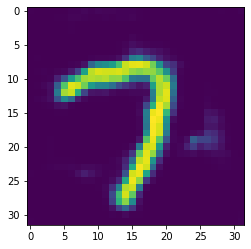

Discriminator out for this image: tensor([[0.1694]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2380
Discriminator loss: 0.1647578738629818
Generator loss: 10.202600002288818
Entering epoch no: 2381
Discriminator loss: 0.40923237800598145
Generator loss: 7.4444262981414795
Entering epoch no: 2382
Discriminator loss: 0.14603044092655182
Generator loss: 8.753050804138184
Entering epoch no: 2383
Discriminator loss: 0.19251764193177223
Generator loss: 8.784450769424438
Entering epoch no: 2384
Discriminator loss: 0.13651663810014725
Generator loss: 10.787268877029419
Entering epoch no: 2385
Discriminator loss: 0.22939907014369965
Generator loss: 12.862412929534912
Entering epoch no: 2386
Discriminator loss: 0.1780753806233406
Generator loss: 14.26742172241211
Entering epoch no: 2387
Discriminator loss: 0.12061508372426033
Generator loss: 14.362657070159912
Entering epoch no: 2388
Discriminator loss: 0.2074296772480011
Generator loss: 15.30973196029663
Entering epoch no: 

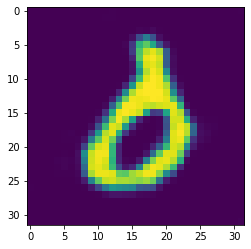

Discriminator out for this image: tensor([[0.0182]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2400
Discriminator loss: 0.6171344816684723
Generator loss: 11.490453004837036
Entering epoch no: 2401
Discriminator loss: 0.3401952236890793
Generator loss: 8.44299578666687
Entering epoch no: 2402
Discriminator loss: 0.38578975945711136
Generator loss: 9.970100164413452
Entering epoch no: 2403
Discriminator loss: 0.11949910782277584
Generator loss: 10.245922565460205
Entering epoch no: 2404
Discriminator loss: 0.2950081527233124
Generator loss: 12.880358695983887
Entering epoch no: 2405
Discriminator loss: 0.3028342127799988
Generator loss: 15.019664764404297
Entering epoch no: 2406
Discriminator loss: 0.3407191336154938
Generator loss: 15.415127754211426
Entering epoch no: 2407
Discriminator loss: 0.6074861586093903
Generator loss: 12.467386960983276
Entering epoch no: 2408
Discriminator loss: 0.21499845385551453
Generator loss: 10.942113161087036
Entering epoch no: 24

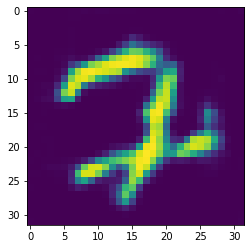

Discriminator out for this image: tensor([[0.0107]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2420
Discriminator loss: 0.1854361817240715
Generator loss: 10.770227432250977
Entering epoch no: 2421
Discriminator loss: 0.19958753138780594
Generator loss: 11.102669954299927
Entering epoch no: 2422
Discriminator loss: 0.11046414077281952
Generator loss: 11.5202317237854
Entering epoch no: 2423
Discriminator loss: 0.273942694067955
Generator loss: 13.254690170288086
Entering epoch no: 2424
Discriminator loss: 0.31360986828804016
Generator loss: 12.381805419921875
Entering epoch no: 2425
Discriminator loss: 0.23549249023199081
Generator loss: 12.437095642089844
Entering epoch no: 2426
Discriminator loss: 0.25174257159233093
Generator loss: 10.688809871673584
Entering epoch no: 2427
Discriminator loss: 0.21449223160743713
Generator loss: 10.197215557098389
Entering epoch no: 2428
Discriminator loss: 0.17256718128919601
Generator loss: 9.964692115783691
Entering epoch no:

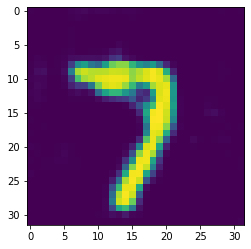

Discriminator out for this image: tensor([[0.2214]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2440
Discriminator loss: 0.3585478514432907
Generator loss: 9.424732208251953
Entering epoch no: 2441
Discriminator loss: 0.16711388528347015
Generator loss: 11.07650089263916
Entering epoch no: 2442
Discriminator loss: 0.27305692434310913
Generator loss: 10.544858455657959
Entering epoch no: 2443
Discriminator loss: 0.24837488681077957
Generator loss: 10.918884515762329
Entering epoch no: 2444
Discriminator loss: 0.23757869005203247
Generator loss: 10.374001264572144
Entering epoch no: 2445
Discriminator loss: 0.19095542281866074
Generator loss: 11.987426280975342
Entering epoch no: 2446
Discriminator loss: 0.24379941821098328
Generator loss: 11.410701036453247
Entering epoch no: 2447
Discriminator loss: 0.185044065117836
Generator loss: 11.900388717651367
Entering epoch no: 2448
Discriminator loss: 0.12615081295371056
Generator loss: 13.411505699157715
Entering epoch no

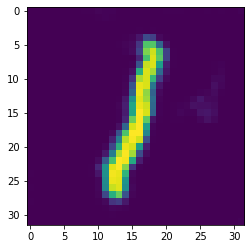

Discriminator out for this image: tensor([[0.0324]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2460
Discriminator loss: 0.2249486967921257
Generator loss: 11.459995031356812
Entering epoch no: 2461
Discriminator loss: 0.32083187997341156
Generator loss: 10.978677034378052
Entering epoch no: 2462
Discriminator loss: 0.1780276596546173
Generator loss: 9.315606117248535
Entering epoch no: 2463
Discriminator loss: 0.14300891011953354
Generator loss: 9.837124586105347
Entering epoch no: 2464
Discriminator loss: 0.24749158322811127
Generator loss: 10.4039626121521
Entering epoch no: 2465
Discriminator loss: 0.13570484146475792
Generator loss: 12.475759029388428
Entering epoch no: 2466
Discriminator loss: 0.33308687806129456
Generator loss: 10.712960720062256
Entering epoch no: 2467
Discriminator loss: 0.09315786696970463
Generator loss: 11.839717626571655
Entering epoch no: 2468
Discriminator loss: 0.19363825768232346
Generator loss: 12.418585777282715
Entering epoch no:

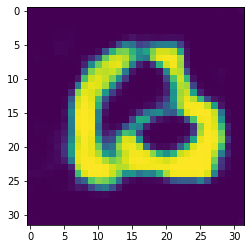

Discriminator out for this image: tensor([[0.0245]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2480
Discriminator loss: 0.4552338868379593
Generator loss: 11.073529720306396
Entering epoch no: 2481
Discriminator loss: 0.20584432780742645
Generator loss: 11.840347290039062
Entering epoch no: 2482
Discriminator loss: 0.2296333760023117
Generator loss: 9.67503809928894
Entering epoch no: 2483
Discriminator loss: 0.4450351595878601
Generator loss: 9.165380239486694
Entering epoch no: 2484
Discriminator loss: 0.2749839723110199
Generator loss: 9.354047775268555
Entering epoch no: 2485
Discriminator loss: 0.14890405163168907
Generator loss: 9.570879936218262
Entering epoch no: 2486
Discriminator loss: 0.1259796405211091
Generator loss: 10.271660327911377
Entering epoch no: 2487
Discriminator loss: 0.18236657232046127
Generator loss: 11.013563394546509
Entering epoch no: 2488
Discriminator loss: 0.208524689078331
Generator loss: 11.873753786087036
Entering epoch no: 2489


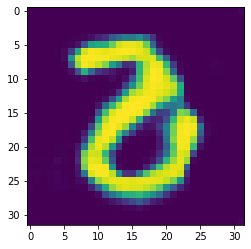

Discriminator out for this image: tensor([[0.0786]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2500
Discriminator loss: 0.18550579249858856
Generator loss: 11.023573160171509
Entering epoch no: 2501
Discriminator loss: 0.19413496553897858
Generator loss: 11.168787717819214
Entering epoch no: 2502
Discriminator loss: 0.13520675152540207
Generator loss: 10.714855670928955
Entering epoch no: 2503
Discriminator loss: 0.3076089471578598
Generator loss: 10.590243816375732
Entering epoch no: 2504
Discriminator loss: 0.16053356975317
Generator loss: 8.095834493637085
Entering epoch no: 2505
Discriminator loss: 0.26313477754592896
Generator loss: 7.298363924026489
Entering epoch no: 2506
Discriminator loss: 0.14889365434646606
Generator loss: 7.366874933242798
Entering epoch no: 2507
Discriminator loss: 0.22983284294605255
Generator loss: 7.5634753704071045
Entering epoch no: 2508
Discriminator loss: 0.25019286572933197
Generator loss: 10.22433590888977
Entering epoch no: 2

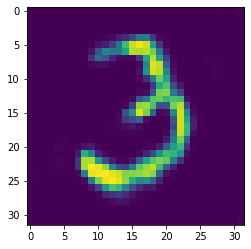

Discriminator out for this image: tensor([[0.1366]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2520
Discriminator loss: 0.19464855641126633
Generator loss: 11.041025161743164
Entering epoch no: 2521
Discriminator loss: 0.13684912770986557
Generator loss: 9.467754125595093
Entering epoch no: 2522
Discriminator loss: 0.26989709585905075
Generator loss: 9.500322580337524
Entering epoch no: 2523
Discriminator loss: 0.1675662249326706
Generator loss: 10.823808908462524
Entering epoch no: 2524
Discriminator loss: 0.18211832642555237
Generator loss: 13.211477279663086
Entering epoch no: 2525
Discriminator loss: 0.14859455451369286
Generator loss: 9.806046485900879
Entering epoch no: 2526
Discriminator loss: 0.4900783598423004
Generator loss: 9.612181186676025
Entering epoch no: 2527
Discriminator loss: 0.18566693365573883
Generator loss: 8.195265293121338
Entering epoch no: 2528
Discriminator loss: 0.20629625022411346
Generator loss: 8.659733772277832
Entering epoch no: 2

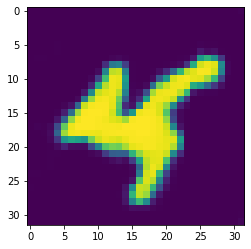

Discriminator out for this image: tensor([[0.1282]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2540
Discriminator loss: 0.15173858404159546
Generator loss: 9.361221313476562
Entering epoch no: 2541
Discriminator loss: 0.2792348563671112
Generator loss: 9.087954998016357
Entering epoch no: 2542
Discriminator loss: 0.3407750353217125
Generator loss: 9.179606676101685
Entering epoch no: 2543
Discriminator loss: 0.1967180073261261
Generator loss: 10.826822757720947
Entering epoch no: 2544
Discriminator loss: 0.22354073822498322
Generator loss: 11.040859699249268
Entering epoch no: 2545
Discriminator loss: 0.27402305603027344
Generator loss: 12.150994539260864
Entering epoch no: 2546
Discriminator loss: 0.3013312816619873
Generator loss: 9.024903535842896
Entering epoch no: 2547
Discriminator loss: 0.2820134162902832
Generator loss: 8.478440523147583
Entering epoch no: 2548
Discriminator loss: 0.24937516450881958
Generator loss: 6.85885763168335
Entering epoch no: 2549


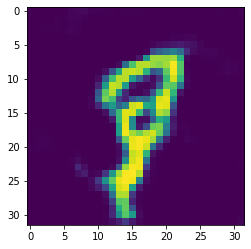

Discriminator out for this image: tensor([[0.1537]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2560
Discriminator loss: 0.1301874853670597
Generator loss: 11.103678703308105
Entering epoch no: 2561
Discriminator loss: 0.21279595792293549
Generator loss: 12.758520126342773
Entering epoch no: 2562
Discriminator loss: 0.2845352739095688
Generator loss: 12.422224521636963
Entering epoch no: 2563
Discriminator loss: 0.18361447751522064
Generator loss: 12.760599613189697
Entering epoch no: 2564
Discriminator loss: 0.11009735614061356
Generator loss: 13.363346576690674
Entering epoch no: 2565
Discriminator loss: 0.29363101720809937
Generator loss: 11.159284591674805
Entering epoch no: 2566
Discriminator loss: 0.14578764885663986
Generator loss: 9.45830249786377
Entering epoch no: 2567
Discriminator loss: 0.25257397443056107
Generator loss: 9.185856342315674
Entering epoch no: 2568
Discriminator loss: 0.13314403593540192
Generator loss: 9.807427406311035
Entering epoch no:

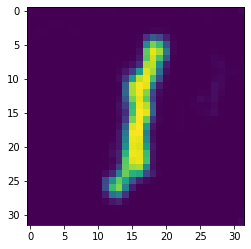

Discriminator out for this image: tensor([[0.0457]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2580
Discriminator loss: 0.2375432252883911
Generator loss: 11.216373920440674
Entering epoch no: 2581
Discriminator loss: 0.450308233499527
Generator loss: 12.756507158279419
Entering epoch no: 2582
Discriminator loss: 0.4547545909881592
Generator loss: 10.56543779373169
Entering epoch no: 2583
Discriminator loss: 0.44279080629348755
Generator loss: 11.99688172340393
Entering epoch no: 2584
Discriminator loss: 0.22689390182495117
Generator loss: 7.232492923736572
Entering epoch no: 2585
Discriminator loss: 0.2501967176795006
Generator loss: 7.837456464767456
Entering epoch no: 2586
Discriminator loss: 0.18126346915960312
Generator loss: 10.296342134475708
Entering epoch no: 2587
Discriminator loss: 0.5153660774230957
Generator loss: 10.940564393997192
Entering epoch no: 2588
Discriminator loss: 0.6388506889343262
Generator loss: 9.456598043441772
Entering epoch no: 2589


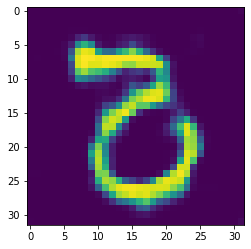

Discriminator out for this image: tensor([[0.0155]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2600
Discriminator loss: 0.4530450701713562
Generator loss: 8.890964031219482
Entering epoch no: 2601
Discriminator loss: 0.4124084711074829
Generator loss: 7.060257196426392
Entering epoch no: 2602
Discriminator loss: 0.4555702805519104
Generator loss: 10.212352275848389
Entering epoch no: 2603
Discriminator loss: 0.3620704561471939
Generator loss: 10.709577560424805
Entering epoch no: 2604
Discriminator loss: 0.34974217414855957
Generator loss: 12.476373672485352
Entering epoch no: 2605
Discriminator loss: 0.3811807781457901
Generator loss: 11.310284614562988
Entering epoch no: 2606
Discriminator loss: 0.19021810591220856
Generator loss: 11.888984680175781
Entering epoch no: 2607
Discriminator loss: 0.5350848734378815
Generator loss: 12.374114990234375
Entering epoch no: 2608
Discriminator loss: 0.30862482637166977
Generator loss: 9.252578735351562
Entering epoch no: 26

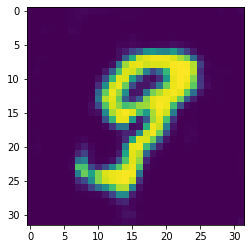

Discriminator out for this image: tensor([[0.0124]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2620
Discriminator loss: 0.3718127906322479
Generator loss: 12.005079507827759
Entering epoch no: 2621
Discriminator loss: 0.24559901654720306
Generator loss: 10.44111156463623
Entering epoch no: 2622
Discriminator loss: 0.2628093510866165
Generator loss: 10.133431673049927
Entering epoch no: 2623
Discriminator loss: 0.2394839972257614
Generator loss: 10.032105445861816
Entering epoch no: 2624
Discriminator loss: 0.2493758127093315
Generator loss: 9.952025890350342
Entering epoch no: 2625
Discriminator loss: 0.1564769744873047
Generator loss: 11.756175518035889
Entering epoch no: 2626
Discriminator loss: 0.09839376993477345
Generator loss: 12.399237394332886
Entering epoch no: 2627
Discriminator loss: 0.23368337750434875
Generator loss: 12.012978076934814
Entering epoch no: 2628
Discriminator loss: 0.15448644757270813
Generator loss: 12.237746238708496
Entering epoch no: 

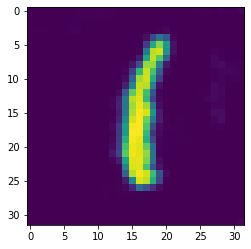

Discriminator out for this image: tensor([[0.0787]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2640
Discriminator loss: 0.3627813458442688
Generator loss: 11.991181373596191
Entering epoch no: 2641
Discriminator loss: 0.2821926027536392
Generator loss: 9.228468179702759
Entering epoch no: 2642


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8bb00aa048>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt: 


Discriminator loss: 0.2613298147916794
Generator loss: 9.260662317276001
Entering epoch no: 2643
Discriminator loss: 0.24305815994739532
Generator loss: 10.131320476531982
Entering epoch no: 2644
Discriminator loss: 0.3339969143271446
Generator loss: 12.672760963439941
Entering epoch no: 2645
Discriminator loss: 0.1924695521593094
Generator loss: 13.86134958267212
Entering epoch no: 2646
Discriminator loss: 0.37448278069496155
Generator loss: 11.459660768508911
Entering epoch no: 2647
Discriminator loss: 0.1582244411110878
Generator loss: 11.435288429260254
Entering epoch no: 2648
Discriminator loss: 0.12575364112854004
Generator loss: 10.269329071044922
Entering epoch no: 2649
Discriminator loss: 0.21619176119565964
Generator loss: 11.790077209472656
Entering epoch no: 2650
Discriminator loss: 0.23777467757463455
Generator loss: 8.93482494354248
Entering epoch no: 2651
Discriminator loss: 0.21034687757492065
Generator loss: 10.34912896156311
Entering epoch no: 2652
Discriminator loss:

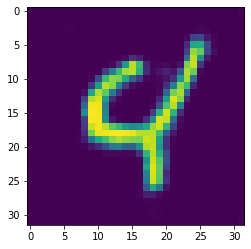

Discriminator out for this image: tensor([[0.0210]], device='cuda:0', grad_fn=<SigmoidBackward>)
Entering epoch no: 2660
Discriminator loss: 0.22006132453680038
Generator loss: 10.036813020706177
Entering epoch no: 2661
Discriminator loss: 0.25832270830869675
Generator loss: 11.042034149169922
Entering epoch no: 2662
Discriminator loss: 0.12488051131367683
Generator loss: 12.541412115097046
Entering epoch no: 2663


KeyboardInterrupt: ignored

In [159]:
num_epochs = 5000
discrimEpochs = 1
genEpochs = 3
for epoch in range(num_epochs):
  print("Entering epoch no: " + str(epoch))
  discrimLoss = 0.0
  for d in range(discrimEpochs):
    if (discrimEpochs == 0):
      break
    #print("Discrim epoch: " + str(d))
    discrimLoss += train_discrim()
  print("Discriminator loss: " + str(discrimLoss))
  genLoss = 0.0
  for g in range(genEpochs):
    #print("Gen epoch: " + str(g))
    genLoss += train_gen()
  print("Generator loss: " + str(genLoss))
  if (epoch % 20 == 19):
    rando = torch.randn([1, 50, 1, 1])
    rando = rando.cuda()
    gen.eval()
    sample = gen(rando)
    sample = sample[0]
    #sample = dataset[100][0]
    #plt.imshow(sample.permute(1,2,0).cpu().detach())
    plt.imshow(sample.reshape([32,32]).cpu().detach())
    plt.show()
    #see what the discrminator thinks
    discrim.eval()
    discrim.batchSize = 1
    sample = sample.cuda()
    #opinion = discrim(sample.reshape([1, 3, 32, 32]))
    opinion = discrim(sample.unsqueeze(0))
    print('Discriminator out for this image: ' + str(opinion))
    discrim.train()
    gen.train()

In [ ]:
rando = torch.randn([1,50,1,1]) + torch.ones([1,50,1,1])
rando = rando.cuda()
gen.eval()
sample = gen(rando)
#plt.imshow(sample[0].permute(1,2,0).cpu().detach())
plt.imshow(sample[0][0].cpu().detach())
plt.show()
#see what the discrminator thinks
discrim.eval()
discrim.batchSize = 1
opinion = discrim(sample)
print('Discriminator out for this image: ' + str(opinion))

rando = torch.randn([1])
halp = dataset[int(rando.item()*100)][0]
halp = halp.cuda()
realop = discrim(halp.unsqueeze(0))
#plt.imshow(halp.permute(1,2,0).cpu())
plt.imshow(halp[0].cpu().detach())
plt.show()
print("Discrim output for real image: " + str(realop))

In [184]:
torch.save(gen, './generator')
torch.save(discrim, './discrim')